In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

from data_processing import *
import data_processing as dp
import metrics


%load_ext autoreload
%autoreload 2

In [2]:
pd.__version__

'1.4.4'

In [3]:
DATADIR = Path('data')

In [4]:
print(os.listdir(DATADIR))

['df_location_ratio.csv', 'df_phq9.csv', 'df_baseline_phq9.csv', 'df_passive_phone_communication_features_brighten_v2.csv', 'df_passive_mobility_features.csv', 'df_demographics.csv', 'data_analysis.ipynb']


# Preparing the Data for Training

## Reading the Data

In [5]:
phq9 = pd.read_csv(DATADIR / 'df_phq9.csv')
phq9.head()

,Unnamed: 0,participant_id,week,sum_phq9,phq9Date,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_level,phq9_level_diff,phq9_sum_diff
0,0,BLUE-00048,1,7,2014-08-08,0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,5.0,1,NaN,NaN
1,1,BLUE-00050,2,7,2014-08-23,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,7.0,2,NaN,NaN
2,2,BLUE-00050,3,4,2014-08-30,1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1,-1.0,-3.0
3,3,BLUE-00050,4,5,2014-09-08,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0.0,1.0
4,4,BLUE-00050,6,5,2014-09-22,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0.0,0.0


In [6]:
demographics = pd.read_csv(DATADIR / 'df_demographics.csv')
demographics.head()

,Unnamed: 0,participant_id,working,income_satisfaction,income_lastyear,age,startdate,study,gen_Female,gen_Male,...,edu_None,edu_University,race_African-American/Black,race_American Indian/Alaskan Native,race_Asian,race_Hispanic/Latino,race_More than one,race_Native Hawaiian/other Pacific Islander,race_Non-Hispanic White,race_Other
0,213,EN00033,1.0,3.0,6.0,52.0,2016-08-12 12:41:00,Brighten-v2,0,1,...,0,1,0,0,0,0,0,0,1,0
1,214,EN00034,1.0,3.0,4.0,32.0,2016-08-12 12:58:00,Brighten-v2,1,0,...,0,1,0,0,0,0,0,0,1,0
2,215,EN00035,0.0,2.0,2.0,57.0,2016-08-12 15:41:00,Brighten-v2,0,1,...,0,1,0,0,0,0,0,0,1,0
3,216,EN00036,1.0,3.0,3.0,55.0,2016-08-13 10:24:00,Brighten-v2,1,0,...,0,1,0,0,0,0,0,0,1,0
4,217,EN00037,0.0,2.0,6.0,34.0,2016-08-15 09:04:00,Brighten-v2,0,1,...,0,1,0,0,0,0,0,0,1,0


In [7]:
demographics.participant_id.unique()
phq9.participant_id.sort_values().unique()

array(['BLUE-00048', 'BLUE-00050', 'BLUE-00051', 'BLUE-00052',
       'BLUE-00053', 'BLUE-00054', 'BLUE-00055', 'BLUE-00058',
       'BLUE-00060', 'BLUE-00062', 'BLUE-00063', 'BLUE-00064',
       'BLUE-00065', 'BLUE-00066', 'BLUE-00067', 'BLUE-00070',
       'BLUE-00072', 'BLUE-00077', 'BLUE-00079', 'BLUE-00082',
       'BLUE-00086', 'BLUE-00088', 'BLUE-00090', 'BLUE-00092',
       'BLUE-00093', 'BLUE-00094', 'BLUE-00096', 'BLUE-00097',
       'BLUE-00100', 'BLUE-00101', 'BLUE-00102', 'BLUE-00104',
       'BLUE-00105', 'BLUE-00107', 'BLUE-00108', 'BLUE-00111',
       'BLUE-00112', 'BLUE-00113', 'BLUE-00114', 'BLUE-00115',
       'BLUE-00119', 'BLUE-00120', 'BLUE-00121', 'BLUE-00122',
       'BLUE-00123', 'BLUE-00125', 'BLUE-00126', 'BLUE-00128',
       'BLUE-00129', 'BLUE-00132', 'BLUE-00133', 'BLUE-00142',
       'BLUE-00144', 'BLUE-00146', 'BLUE-00148', 'BLUE-00149',
       'BLUE-00157', 'BLUE-00159', 'BLUE-00162', 'BLUE-00164',
       'BLUE-00165', 'BLUE-00166', 'BLUE-00168', 'BLUE-

In [8]:
locations = pd.read_csv(DATADIR / 'df_location_ratio.csv')
locations.head()

,participant_id,date,automotive,consumer_goods,dining_out,education,entertainment,finance,government_offices,health,...,home_store,lodging,park,personal_services,place_of_mourning,place_of_worship,repair,supermarket,transit,work
0,EN00039,2016-09-15,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EN00039,2016-09-17,0.0,0.0,0.0,0.011111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EN00039,2016-11-11,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EN00039,2016-11-13,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,EN00039,2016-11-14,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cleaning a bit More

In [9]:
phq9.rename(columns={'phq9Date': 'date'}, inplace=True)

In [10]:
phq9.head()

,Unnamed: 0,participant_id,week,sum_phq9,date,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_level,phq9_level_diff,phq9_sum_diff
0,0,BLUE-00048,1,7,2014-08-08,0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,5.0,1,NaN,NaN
1,1,BLUE-00050,2,7,2014-08-23,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,7.0,2,NaN,NaN
2,2,BLUE-00050,3,4,2014-08-30,1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1,-1.0,-3.0
3,3,BLUE-00050,4,5,2014-09-08,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0.0,1.0
4,4,BLUE-00050,6,5,2014-09-22,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1,0.0,0.0


# Basic Training (No CV)

In [8]:
# Check balanced accuracy instead of raw and plot distributions
# Maybe look at the distr of the RMSE for regression

# Also, maybe use the std. instead of just the mean for features
# Try to use significant cross-validation
# Maybe apply feature selection:
#    * Automatic feature selection
#    * Manual: e.g. greatly reduce the number of location categories except for work and home
# Try to see the effect of some hyperparameters of the random forest

# Use only a few initial weeks in training for some patients
# Maybe try to improve the context with previous information

# Try different targets:
#    * The original sum_phq9 (not the column sum of 9 questions)
#    * Target each question separately

def train(TYPE='classification', TARGET='value', SPLIT_BY_PARTICIPANT=False, TEST_TAKE_FIRST=0, SEED=550, 
          return_csv=False, return_dataset=False):

    phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET)
    locations = load_locations(DATADIR / 'df_location_ratio.csv')
    demographics = load_demographics(DATADIR / 'df_demographics.csv')
    mobility = load_passive_mobility(DATADIR / 'df_passive_mobility_features.csv')
    phone = load_passive_phone(DATADIR / 'df_passive_phone_communication_features_brighten_v2.csv')

    combined, merge_result = dp.combine(
        phq9, 
        dailies=[
            ('locations', locations), 
            # ('mobility', mobility),
            # ('phone', phone)
        ], 
        constants=[
            demographics
        ],
        prev_phq9=False
    )
    combined = dp.rf_preprocess(combined)

    if return_csv:
        return combined
    
    if SPLIT_BY_PARTICIPANT:
        x_train, x_test, y_train, y_test = dp.train_test_split_participant(combined, 0.15, random_state=SEED,
                                                                           test_take_first=TEST_TAKE_FIRST)
    else:
        x, y = dp.xy_split(combined)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=SEED, stratify=y)

    if return_dataset:
        return x_train, x_test, y_train, y_test
        
    print('Train set shape:', x_train.shape)
    print('Test set shape:', x_test.shape)
    n = len(y_train) + len(y_test)
    train_pct = len(y_train) / n * 100
    test_pct = len(y_test) / n * 100
    print(f'Ratio: {train_pct:.2f}%/{test_pct:.2f}%')
    print()


    if TYPE == 'regression':
        def rmse(x, y):
            return np.sqrt(((x - y)**2).mean())

        model = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)

        train_rmse = rmse(y_train, model.predict(x_train))
        test_rmse = rmse(y_test, model.predict(x_test))
        print(f'Train set RMSE: {train_rmse:.4f}')
        print(f'Test set RMSE:  {test_rmse:.4f}')

        train_score = model.score(x_train, y_train)
        test_score = model.score(x_test, y_test)
        print(f'Train score:', train_score)
        print(f'Test score:', test_score)
        
        return train_score, test_score
    elif TYPE == 'classification':

        model = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)

        y_full = np.concatenate((y_train, y_test))
        random_acc = 100 * (y_full == np.random.randint(0, 5, size=y_full.shape)).mean()
        # train_acc = 100 * model.score(x_train, y_train)
        # test_acc = 100 * model.score(x_test, y_test)
        # print(f'Train set accuracy: {train_acc:.2f}%') 
        # print(f'Test set accuracy:  {test_acc:.2f}%')
        print(f'Random full accuracy: {random_acc:.2f}%')

        figs, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        print('Train set:')
        train_bal, train_mean = metrics.accuracy_info(y_train, model.predict(x_train), prefix='Training', ax=axes[0])

        print('Test set:')
        test_bal, test_mean = metrics.accuracy_info(y_test, model.predict(x_test), prefix='Test', ax=axes[1])
        
        return train_bal, test_bal

In [12]:
TYPE='classification'
TARGET='value'
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET)
locations = load_locations(DATADIR / 'df_location_ratio.csv')
demographics = load_demographics(DATADIR / 'df_demographics.csv')
mobility = load_passive_mobility(DATADIR / 'df_passive_mobility_features.csv')
phone = load_passive_phone(DATADIR / 'df_passive_phone_communication_features_brighten_v2.csv')

combined, merge_result = dp.combine(
    phq9, 
    dailies=[
        ('locations', locations), 
        # ('mobility', mobility),
        # ('phone', phone)
    ], 
    constants=[
        demographics
    ],
    prev_phq9=False
)
combined = dp.rf_preprocess(combined)

In [55]:
from itertools import count
combined.head()
groups = [g for _, g in combined.groupby('participant_id')]
groups[4]
ids = combined.participant_id.unique()
repl_dict = {id: i for id, i in zip(ids, count(0))}
repl_dict
replaced = combined.replace(repl_dict)
replaced.head()
df = pd.DataFrame(combined.to_numpy())

groups = [g.drop(0, axis=1) for i, g in df.groupby(0)]
# groups[3].drop(1, axis=1).to_numpy().astype(np.float64)
groups[0].shape

(4, 63)

***ITER***
Random full accuracy: 18.95%
Train set:
Mean accuracy: 95.259%
Balanced accuracy: 95.621%
Test set:
Mean accuracy: 29.614%
Balanced accuracy: 21.264%
***ITER***
Random full accuracy: 20.16%
Train set:
Mean accuracy: 95.156%
Balanced accuracy: 95.444%
Test set:
Mean accuracy: 23.276%
Balanced accuracy: 20.165%
***ITER***
Random full accuracy: 18.78%
Train set:
Mean accuracy: 94.618%
Balanced accuracy: 95.182%
Test set:
Mean accuracy: 19.397%
Balanced accuracy: 18.020%
***ITER***
Random full accuracy: 22.14%
Train set:
Mean accuracy: 93.649%
Balanced accuracy: 94.250%
Test set:
Mean accuracy: 17.672%
Balanced accuracy: 15.479%
***ITER***
Random full accuracy: 19.12%
Train set:
Mean accuracy: 94.833%
Balanced accuracy: 95.200%
Test set:
Mean accuracy: 27.586%
Balanced accuracy: 23.818%


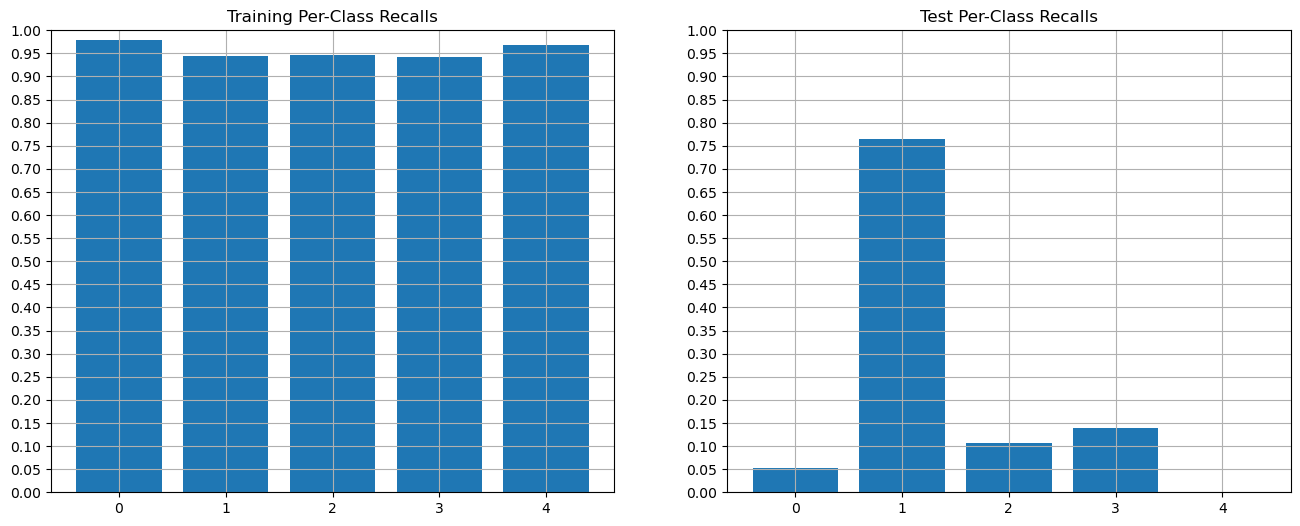

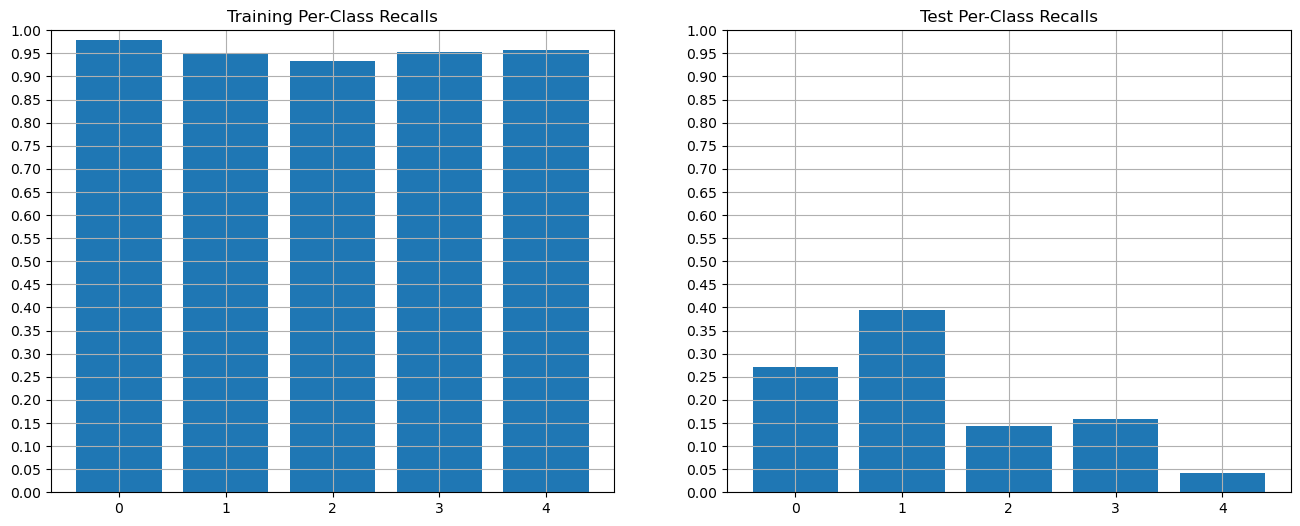

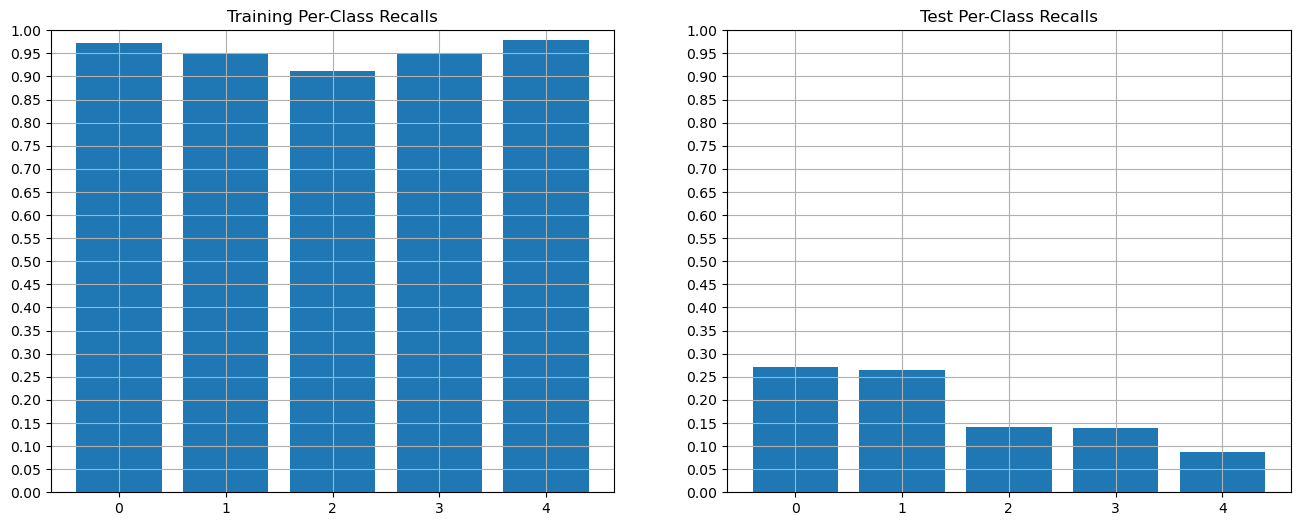

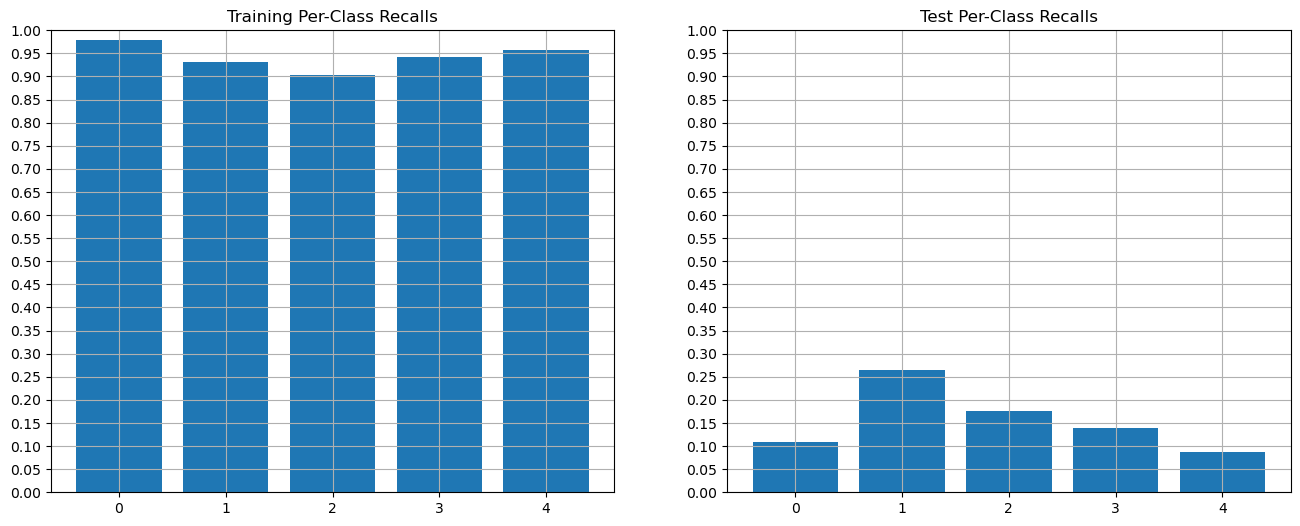

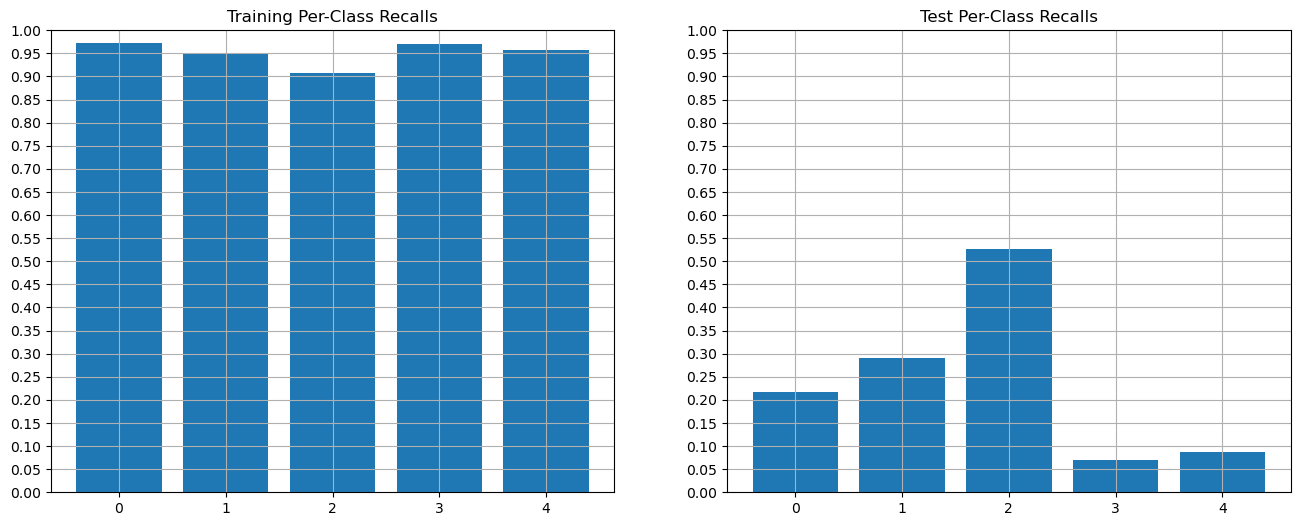

In [25]:
metric_dict = train_cv(SPLIT_BY_PARTICIPANT=False, TEST_TAKE_FIRST=0)

In [23]:
phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type='classification', target='value')
locations = load_locations(DATADIR / 'df_location_ratio.csv')
demographics = load_demographics(DATADIR / 'df_demographics.csv')
mobility = load_passive_mobility(DATADIR / 'df_passive_mobility_features.csv')
phone = load_passive_phone(DATADIR / 'df_passive_phone_communication_features_brighten_v2.csv')

combined, merge_result = dp.combine(
    phq9, 
    dailies=[
        ('locations', locations), 
        # ('mobility', mobility),
        # ('phone', phone)
    ], 
    constants=[
        demographics
    ],
    prev_phq9=False
)
SPLIT_BY_PARTICIPANT = False
N_SPLIT = 8
TEST_TAKE_FIRST = 1
combined = dp.rf_preprocess(combined)
gen = cv.per_patient_cv(combined, N_SPLIT, TEST_TAKE_FIRST, model_class) if SPLIT_BY_PARTICIPANT else cv.per_row_cv(combined, N_SPLIT) 
for x_train, x_test, y_train, y_test in gen:
    print('A')

A
A
A
A
A
A
A
A


In [26]:
metric_dict

defaultdict(list,
            {'train_bal': [0.95621112639246,
              0.9544361525458827,
              0.951818852340107,
              0.9424955136442875,
              0.951999719007104],
             'train_mean': [0.95621112639246,
              0.9544361525458827,
              0.951818852340107,
              0.9424955136442875,
              0.951999719007104],
             'test_bal': [0.21263964174000888,
              0.20165023721361747,
              0.18020028836244045,
              0.15478539978965716,
              0.23818452719123254],
             'test_mean': [0.21263964174000888,
              0.20165023721361747,
              0.18020028836244045,
              0.15478539978965716,
              0.23818452719123254]})

In [28]:
combined.participant_id.unique().size

285

# Experiments with Taking N First Rows from Test Participants

1161 285


Text(0.5, 1.0, 'Distribution of # Rows per Participant')

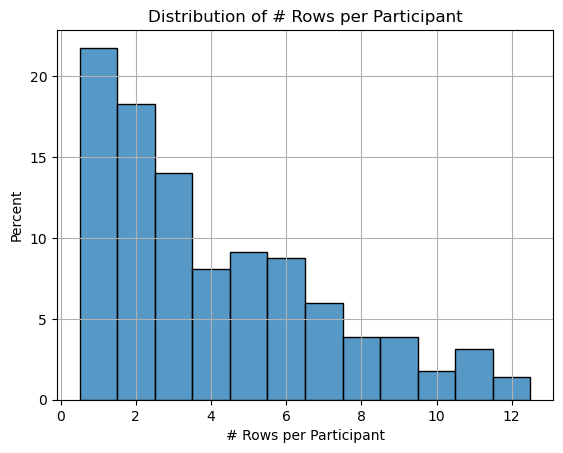

In [11]:
csv = train(return_csv=True)
print(len(csv), csv.participant_id.unique().size)
sizes = csv.groupby('participant_id').size()
sns.histplot(sizes, discrete=True, stat='percent')
plt.grid()
plt.xlabel('# Rows per Participant')
plt.title('Distribution of # Rows per Participant')

After test_take_first=1, have 89.06% (285) vs. 10.94 (35) participants in train/test set
After test_take_first=2, have 90.76% (285) vs. 9.24 (29) participants in train/test set
After test_take_first=3, have 93.44% (285) vs. 6.56 (20) participants in train/test set
After test_take_first=4, have 94.06% (285) vs. 5.94 (18) participants in train/test set


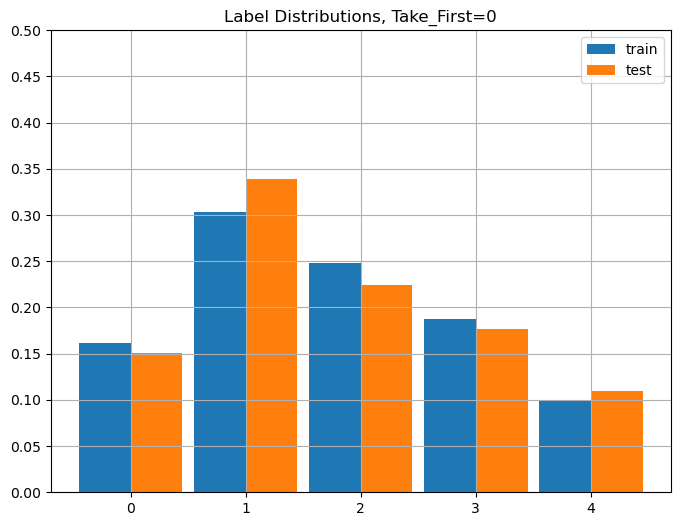

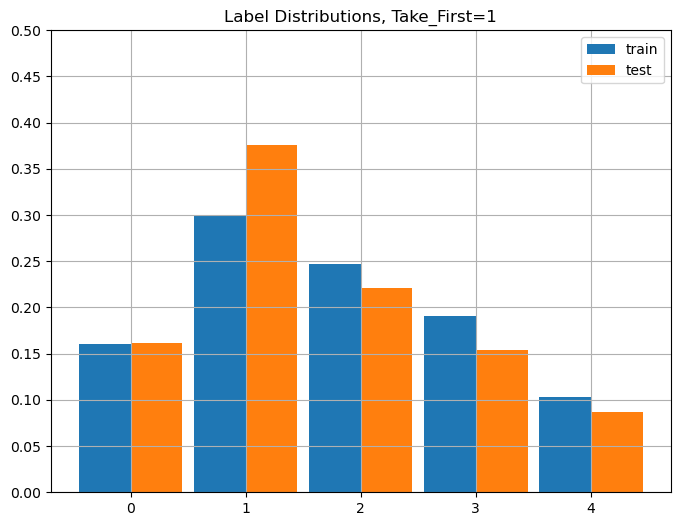

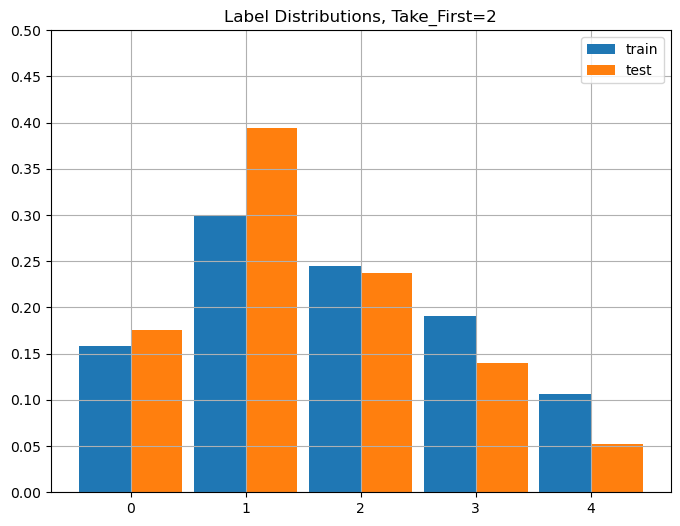

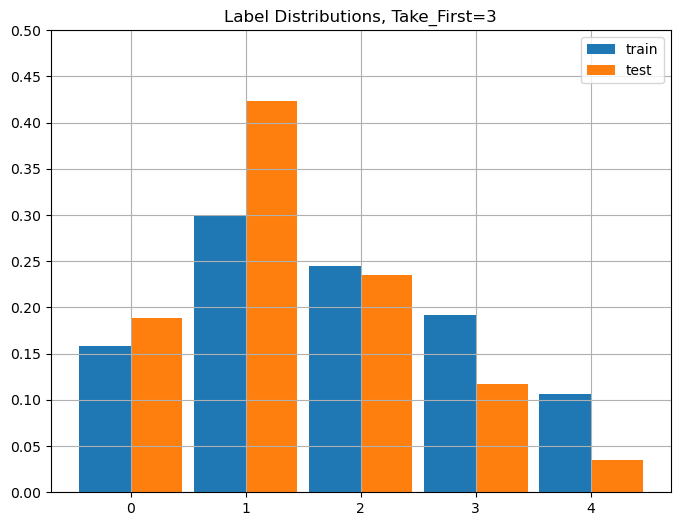

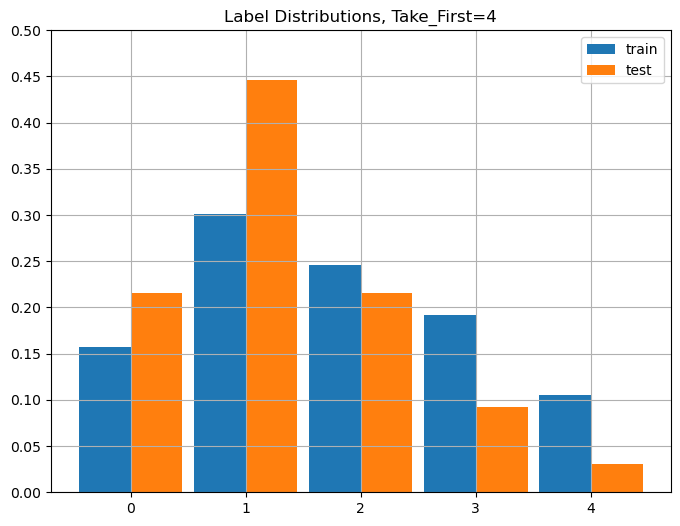

In [18]:
for tf in range(5):
    _, _, y_train, y_test = train(SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=tf, return_dataset=True)
    figs, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.hist([y_train, y_test], bins=np.arange(-0.5, 4.6), rwidth=0.9, density=True, label=['train', 'test'])
    ax.set_title(f'Label Distributions, Take_First={tf}')
    ax.legend()
    ax.grid()
    ax.set_ylim([0, 0.5])
    ax.set_yticks(np.arange(0.00, 0.51, 0.05))

***** TAKE FIRST N=0 *****
Train set shape: (969, 61)
Test set shape: (192, 61)
Ratio: 83.46%/16.54%

Random full accuracy: 17.92%
Train set:
Mean accuracy: 94.118%
Balanced accuracy: 94.597%
Test set:
Mean accuracy: 26.562%
Balanced accuracy: 24.081%
***** TAKE FIRST N=1 *****
After test_take_first=1, have 89.06% (285) vs. 10.94 (35) participants in train/test set
Train set shape: (1012, 61)
Test set shape: (149, 61)
Ratio: 87.17%/12.83%

Random full accuracy: 18.60%
Train set:
Mean accuracy: 94.269%
Balanced accuracy: 94.662%
Test set:
Mean accuracy: 48.322%
Balanced accuracy: 47.805%
***** TAKE FIRST N=2 *****
After test_take_first=2, have 90.76% (285) vs. 9.24 (29) participants in train/test set
Train set shape: (1047, 61)
Test set shape: (114, 61)
Ratio: 90.18%/9.82%

Random full accuracy: 18.35%
Train set:
Mean accuracy: 94.174%
Balanced accuracy: 94.547%
Test set:
Mean accuracy: 43.860%
Balanced accuracy: 46.009%
***** TAKE FIRST N=3 *****
After test_take_first=3, have 93.44% (2

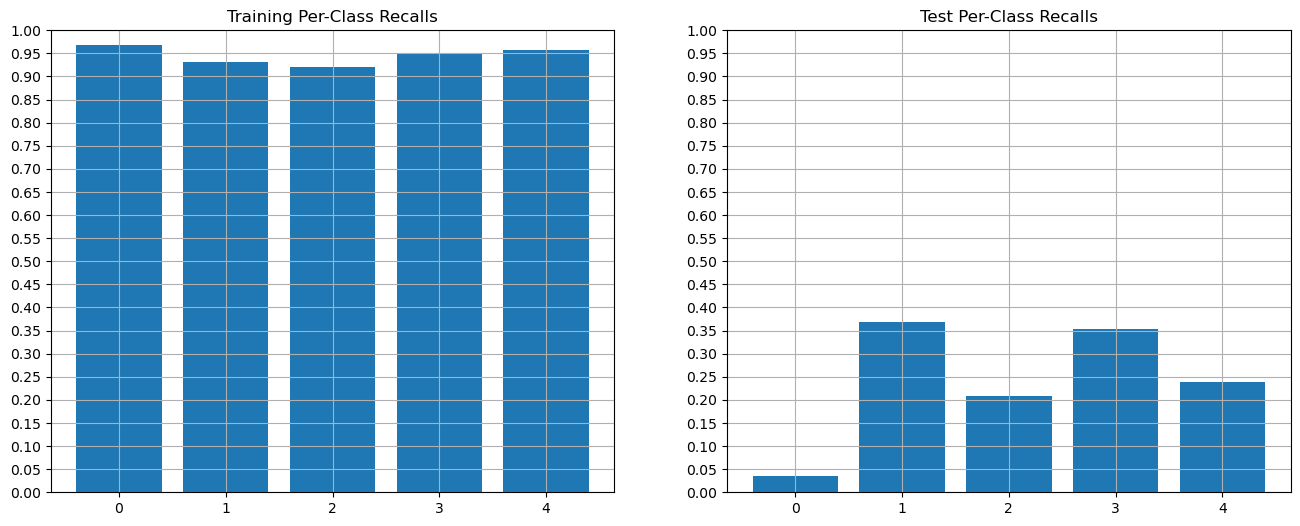

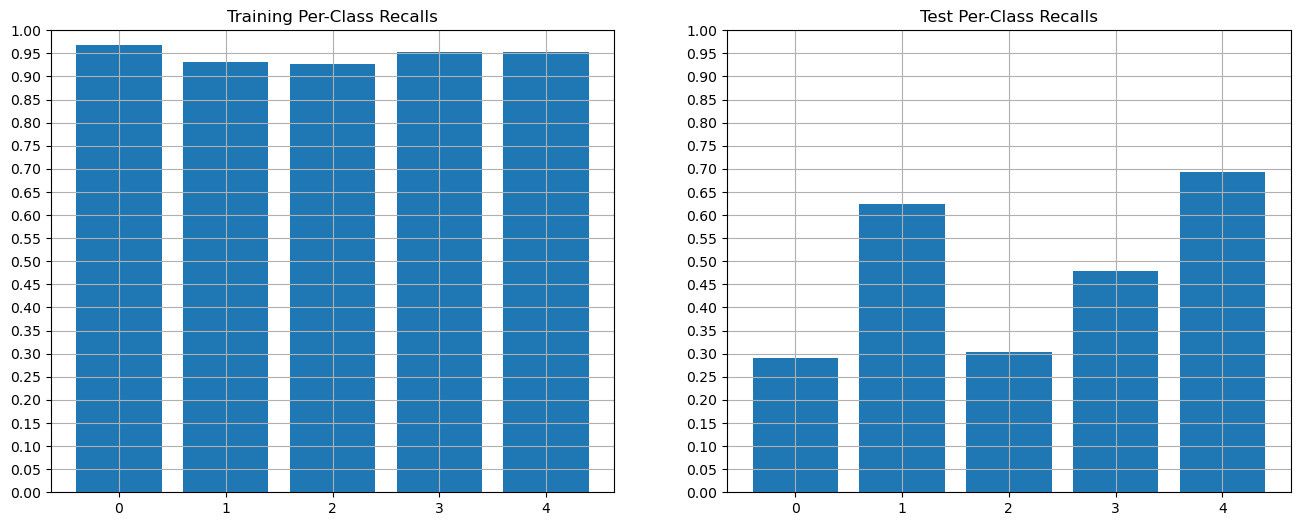

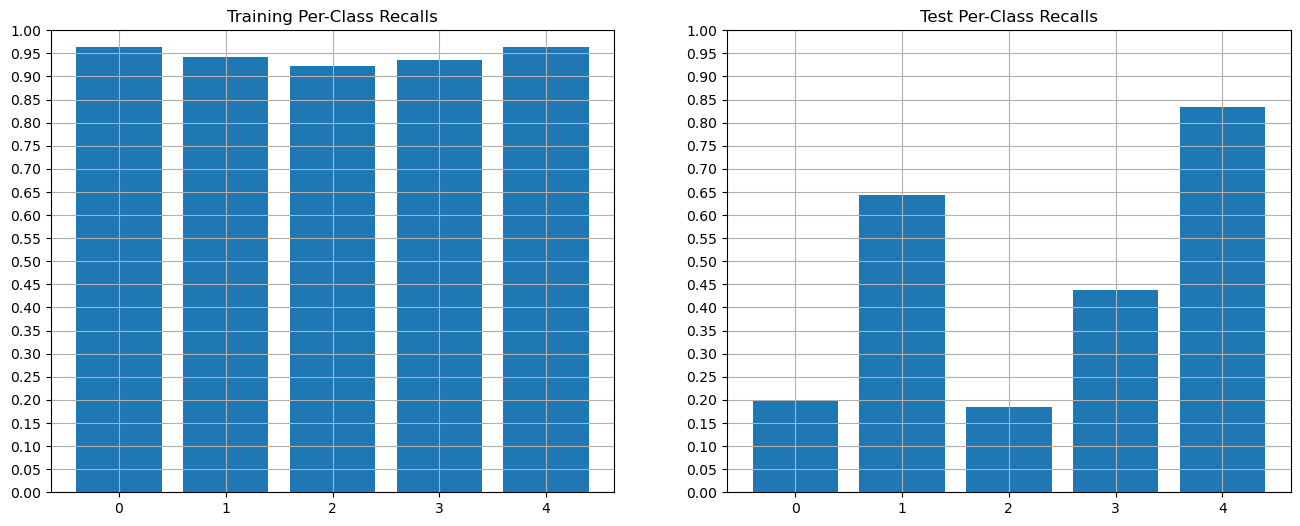

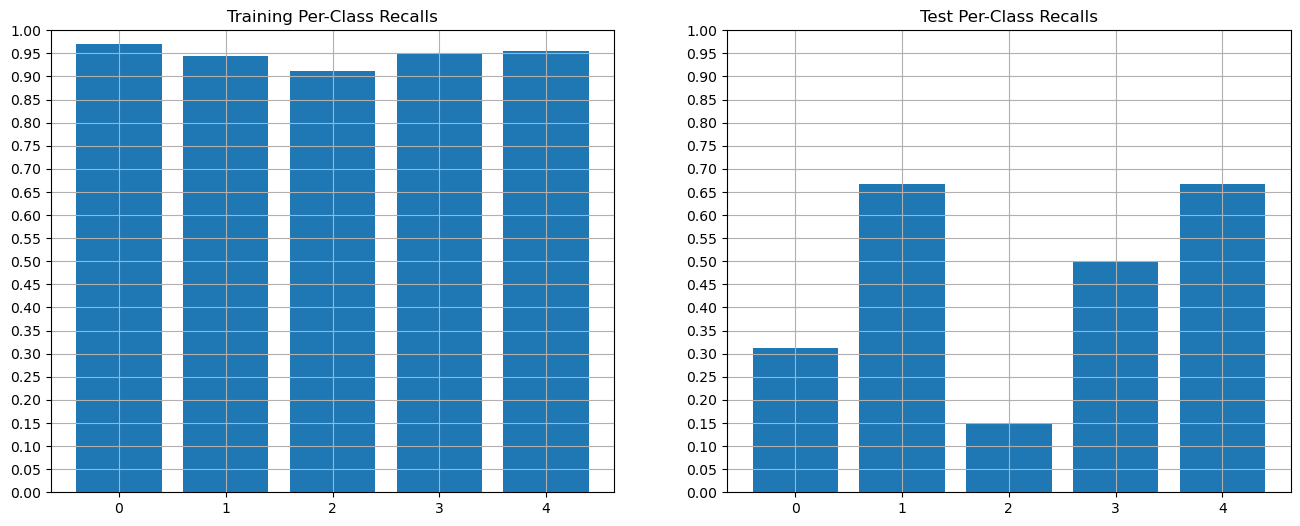

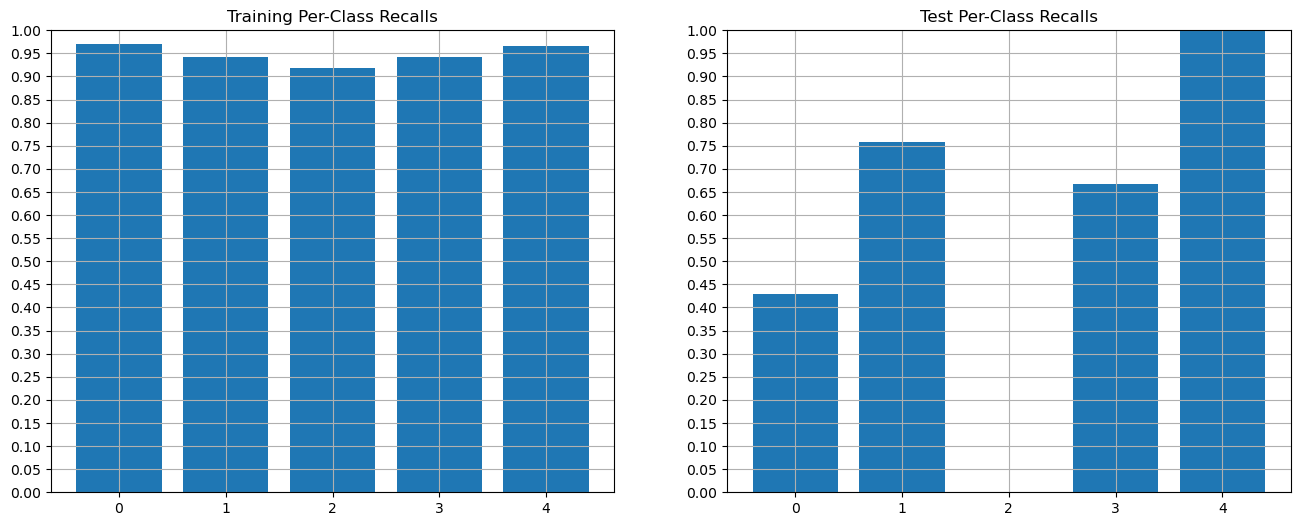

In [566]:
trains = []
tests = []
for tf in range(5):
    print(f'***** TAKE FIRST N={tf} *****')
    train_bal, test_bal = train(SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=tf)
    trains.append(train_bal)
    tests.append(test_bal)

Text(0, 0.5, 'Balanced Accuracy')

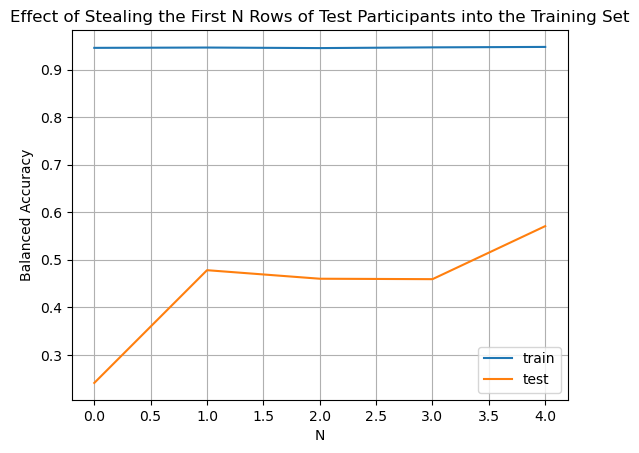

In [582]:
plt.figure()
plt.plot(range(5), trains, label='train')
plt.plot(range(5), tests, label='test')
plt.legend()
plt.grid()
plt.title('Effect of Stealing the First N Rows of Test Participants into the Training Set')
plt.xlabel('N')
plt.ylabel('Balanced Accuracy')

## Training with CV

In [113]:
# Check balanced accuracy instead of raw and plot distributions
# Maybe look at the distr of the RMSE for regression

# Also, maybe use the std. instead of just the mean for features
# Try to use significant cross-validation
# Maybe apply feature selection:
#    * Automatic feature selection
#    * Manual: e.g. greatly reduce the number of location categories except for work and home
# Try to see the effect of some hyperparameters of the random forest

# Use only a few initial weeks in training for some patients
# Maybe try to improve the context with previous information

# Try different targets:
#    * The original sum_phq9 (not the column sum of 9 questions)
#    * Target each question separately
from collections import defaultdict
import cv
from data_processing import *
import data_processing as dp
import metrics
from models import *

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def train_cv(MODEL_TYPE='random-forest', TYPE='classification', TARGET='value', SPLIT_BY_PARTICIPANT=False, TEST_TAKE_FIRST=0, SEED=550, N_SPLIT=5, return_csv=False, use_counts=False):
    phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET)
    locations = load_locations(DATADIR / 'df_location_ratio.csv')
    demographics = load_demographics(DATADIR / 'df_demographics.csv')
    mobility = load_passive_mobility(DATADIR / 'df_passive_mobility_features.csv')
    phone = load_passive_phone(DATADIR / 'df_passive_phone_communication_features_brighten_v2.csv')

    combined, merge_result = dp.combine(
        phq9, 
        dailies=[
            ('locations', locations), 
            # ('mobility', mobility),
            # ('phone', phone)
        ], 
        constants=[
            demographics
        ],
        prev_phq9=False
    )
    
    type2cls = {
        'random-forest': (SKLearnRandomForest, {'n_estimators': 300, 'n_jobs': -1, 'random_state': SEED}),
        'rnn': (LitRNNModel, {'hidden_size': 128, 'num_layers': 2}),
    }
    
    model_class, model_kwargs = type2cls[MODEL_TYPE]
    
    combined = model_class.preprocess(combined)

    if return_csv:
        return combined

    # print('Train set shape:', x_train.shape)
    # print('Test set shape:', x_test.shape)
    # n = len(y_train) + len(y_test)
    # train_pct = len(y_train) / n * 100
    # test_pct = len(y_test) / n * 100
    # print(f'Ratio: {train_pct:.2f}%/{test_pct:.2f}%')
    # print()


    metric_dict = defaultdict(list)
    gen = cv.per_patient_cv(combined, N_SPLIT, TEST_TAKE_FIRST, split_fn=model_class.xy_split)\
          if SPLIT_BY_PARTICIPANT\
          else cv.per_row_cv(combined, N_SPLIT, split_fn=model_class.xy_split) 
    for i, (x_train, x_test, y_train, y_test) in enumerate(gen):
        print(f'--- Split {i} ---')
        if x_train is None:
            print('Skipped, because take first emptied the test set.')
            continue
        if TYPE == 'regression':
            def rmse(x, y):
                return np.sqrt(((x - y)**2).mean())

            model = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=SEED)
            model.fit(x_train, y_train)

            train_rmse = rmse(y_train, model.predict(x_train))
            test_rmse = rmse(y_test, model.predict(x_test))
            print(f'Train set RMSE: {train_rmse:.4f}')
            print(f'Test set RMSE:  {test_rmse:.4f}')
            
            train_score = model.score(x_train, y_train)
            test_score = model.score(x_test, y_test)
            print(f'Train score:', train_score)
            print(f'Test score:', test_score)

            return train_score, test_score
        elif TYPE == 'classification':

            model = model_class(**model_kwargs)
            model.fit(x_train, y_train)

            y_full = np.concatenate((y_train, y_test))
            random_acc = 100 * (y_full == np.random.randint(0, 5, size=y_full.shape)).mean()
            # train_acc = 100 * model.score(x_train, y_train)
            # test_acc = 100 * model.score(x_test, y_test)
            # print(f'Train set accuracy: {train_acc:.2f}%') 
            # print(f'Test set accuracy:  {test_acc:.2f}%')
            print(f'Random full accuracy: {random_acc:.2f}%')

            # figs, axes = plt.subplots(1, 2, figsize=(16, 6))
            axes = [None, None]


            print('Train set:')
            train_bal, train_mean = metrics.accuracy_info(y_train, model.predict(x_train), prefix='Training', ax=axes[0], plot=False)


            print('Test set:')
            test_bal, test_mean = metrics.accuracy_info(y_test, model.predict(x_test), prefix='Test', ax=axes[1], plot=False)

            metric_dict['train_bal'].append(train_bal)
            metric_dict['train_mean'].append(train_mean)
            metric_dict['test_bal'].append(test_bal)
            metric_dict['test_mean'].append(test_mean)
            
    for k, v in metric_dict.items():
        metric_dict[k] = np.array(v)
            
    return metric_dict

## Effect of Stealing K First Rows with Cross-Validation (10 Splits)

In [114]:
%%time

import warnings
warnings.simplefilter("ignore")

trains = []
tests = []
train_errs, test_errs = [], []
for tf in range(3):
    print(f'***** TAKE FIRST N={tf} *****')
    metric_dict = train_cv(MODEL_TYPE='rnn', SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=tf, N_SPLIT=5)
    print(metric_dict)
    trains.append(metric_dict['train_bal'].mean())
    train_errs.append(metric_dict['train_bal'].std())
    tests.append(metric_dict['test_bal'].mean())
    test_errs.append(metric_dict['test_bal'].std())

***** TAKE FIRST N=0 *****
Cached name: dailiesIlocationsI_constantsI1I_prev_phq9IFalseI_reducImean,stdI
Found matching cached data at 'cache/dailiesIlocationsI_constantsI1I_prev_phq9IFalseI_reducImean,stdI_combined.pkl', loading from cache.
--- Split 0 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 17.83%
Train set:
Mean accuracy: 89.871%
Balanced accuracy: 89.546%
Test set:
Mean accuracy: 21.030%
Balanced accuracy: 19.591%
--- Split 1 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 20.41%
Train set:
Mean accuracy: 89.236%
Balanced accuracy: 88.863%
Test set:
Mean accuracy: 25.431%
Balanced accuracy: 22.096%
--- Split 2 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 20.59%
Train set:
Mean accuracy: 90.312%
Balanced accuracy: 90.385%
Test set:
Mean accuracy: 28.879%
Balanced accuracy: 28.059%
--- Split 3 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 18.52%
Train set:
Mean accuracy: 91.173%
Balanced accuracy: 90.567%
Test set:
Mean accuracy: 21.121%
Balanced accuracy: 19.755%
--- Split 4 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 19.55%
Train set:
Mean accuracy: 91.389%
Balanced accuracy: 90.645%
Test set:
Mean accuracy: 28.448%
Balanced accuracy: 26.008%
defaultdict(<class 'list'>, {'train_bal': array([0.89546312, 0.88863486, 0.90384802, 0.90566935, 0.90645468]), 'train_mean': array([0.8987069 , 0.89235737, 0.90312164, 0.91173305, 0.9138859 ]), 'test_bal': array([0.19590662, 0.22095696, 0.28058513, 0.19754768, 0.26007527]), 'test_mean': array([0.21030043, 0.25431034, 0.2887931 , 0.2112069 , 0.28448276])})
***** TAKE FIRST N=1 *****
Cached name: dailiesIlocationsI_constantsI1I_prev_phq9IFalseI_reducImean,stdI
Found matching cached data at 'cache/dailiesIlocationsI_constantsI1I_prev_phq9IFalseI_reducImean,stdI_combined.pkl', loading from cache.
--- Split 0 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 19.90%
Train set:
Mean accuracy: 86.842%
Balanced accuracy: 85.664%
Test set:
Mean accuracy: 21.387%
Balanced accuracy: 17.988%
--- Split 1 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 18.78%
Train set:
Mean accuracy: 89.137%
Balanced accuracy: 89.096%
Test set:
Mean accuracy: 20.455%
Balanced accuracy: 17.553%
--- Split 2 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 20.50%
Train set:
Mean accuracy: 88.337%
Balanced accuracy: 88.538%
Test set:
Mean accuracy: 30.857%
Balanced accuracy: 29.710%
--- Split 3 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 18.69%
Train set:
Mean accuracy: 90.447%
Balanced accuracy: 90.710%
Test set:
Mean accuracy: 24.859%
Balanced accuracy: 21.734%
--- Split 4 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 19.98%
Train set:
Mean accuracy: 89.351%
Balanced accuracy: 89.268%
Test set:
Mean accuracy: 28.571%
Balanced accuracy: 23.982%
defaultdict(<class 'list'>, {'train_bal': array([0.8566355 , 0.89095983, 0.8853845 , 0.90710291, 0.89267599]), 'train_mean': array([0.86842105, 0.89137056, 0.88336714, 0.90447154, 0.89350913]), 'test_bal': array([0.17988392, 0.17553296, 0.29709852, 0.21733586, 0.23981708]), 'test_mean': array([0.21387283, 0.20454545, 0.30857143, 0.24858757, 0.28571429])})
***** TAKE FIRST N=2 *****
Cached name: dailiesIlocationsI_constantsI1I_prev_phq9IFalseI_reducImean,stdI
Found matching cached data at 'cache/dailiesIlocationsI_constantsI1I_prev_phq9IFalseI_reducImean,stdI_combined.pkl', loading from cache.
--- Split 0 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 19.55%
Train set:
Mean accuracy: 89.265%
Balanced accuracy: 88.324%
Test set:
Mean accuracy: 20.472%
Balanced accuracy: 20.238%
--- Split 1 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 19.21%
Train set:
Mean accuracy: 87.670%
Balanced accuracy: 87.864%
Test set:
Mean accuracy: 23.664%
Balanced accuracy: 19.996%
--- Split 2 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 19.29%
Train set:
Mean accuracy: 90.592%
Balanced accuracy: 89.672%
Test set:
Mean accuracy: 30.000%
Balanced accuracy: 26.269%
--- Split 3 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 17.40%
Train set:
Mean accuracy: 87.829%
Balanced accuracy: 86.963%
Test set:
Mean accuracy: 21.642%
Balanced accuracy: 18.451%
--- Split 4 ---
Determined num_classes=5 input_dim=61


Training: 0it [00:00, ?it/s]

Random full accuracy: 18.86%
Train set:
Mean accuracy: 88.544%
Balanced accuracy: 88.614%
Test set:
Mean accuracy: 26.718%
Balanced accuracy: 23.832%
defaultdict(<class 'list'>, {'train_bal': array([0.88323719, 0.87864409, 0.89672348, 0.86963054, 0.88614151]), 'train_mean': array([0.8926499 , 0.87669903, 0.90591659, 0.87828627, 0.88543689]), 'test_bal': array([0.20238455, 0.19996348, 0.2626862 , 0.18451353, 0.23831935]), 'test_mean': array([0.20472441, 0.23664122, 0.3       , 0.21641791, 0.26717557])})
CPU times: user 5min 26s, sys: 1min 29s, total: 6min 55s
Wall time: 5min 53s


Text(0, 0.5, 'Balanced Accuracy')

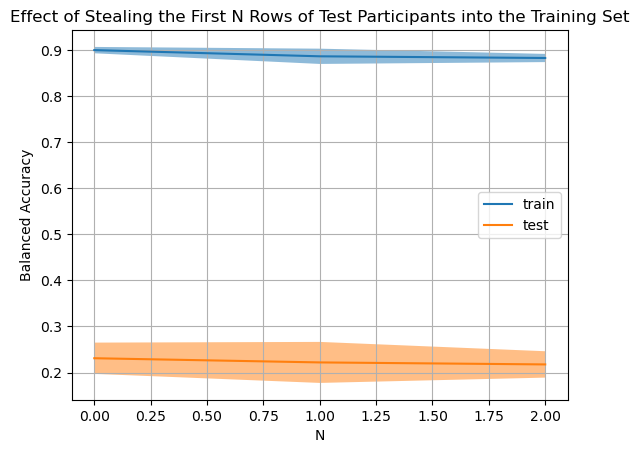

In [115]:
plt.figure()
tests = np.array(tests)
trains = np.array(trains)
test_errs = np.array(test_errs)
train_errs = np.array(train_errs)
k = len(trains)
plt.plot(range(k), trains, label='train')
plt.plot(range(k), tests, label='test')
plt.fill_between(range(k), trains - train_errs, trains + train_errs, alpha=0.5)
plt.fill_between(range(k), tests - test_errs, tests + test_errs, alpha=0.5)
plt.legend()
plt.grid()
plt.title('Effect of Stealing the First N Rows of Test Participants into the Training Set')
plt.xlabel('N')
plt.ylabel('Balanced Accuracy')

Text(0, 0.5, 'Balanced Accuracy')

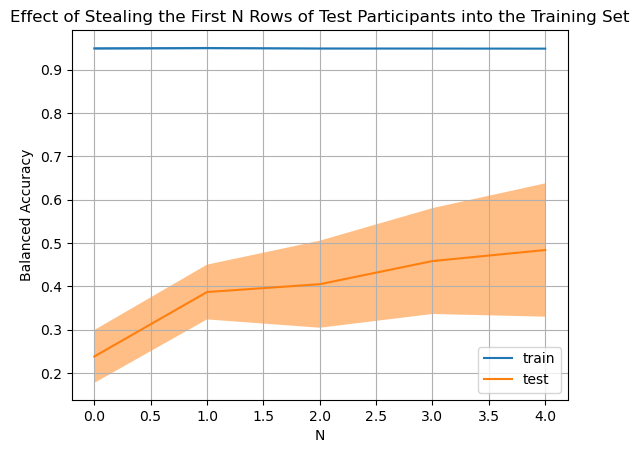

In [40]:
plt.figure()
tests = np.array(tests)
train = np.array(train)
test_errs = np.array(test_errs)
train_errs = np.array(train_errs)
plt.plot(range(5), trains, label='train')
plt.plot(range(5), tests, label='test')
plt.fill_between(range(5), trains - train_errs, trains + train_errs, alpha=0.5)
plt.fill_between(range(5), tests - test_errs, tests + test_errs, alpha=0.5)
plt.legend()
plt.grid()
plt.title('Effect of Stealing the First N Rows of Test Participants into the Training Set')
plt.xlabel('N')
plt.ylabel('Balanced Accuracy')

## Effect of Stealing K First Rows with Cross-Validation (Leave-One-Patient-Out)

Issue: Cannot really calculate balanced accuracy with one patient in test set, some classes will be missing

1. If we simply count and sum up all correct/incorrect predictions, can get mean accuracy, but no error bar since we still don't have per-split accuracies
1. For maximum correctness, maybe leave unavailable classes as NaN and output per-class-accuracy vector per split, e.g. [0.2, NaN, 0.5, NaN, NaN]. At the end, aggregate these to find mean/std of accuracies for each class. Calculate balanced accuracy as the mean of the final aggregations. How to find std of this balanced accuracy though?
1. Calculate balanced accuracy for each class by simply ignoring NaNs. 


In [50]:
%%time
trains = []
tests = []
train_errs, test_errs = [], []
for tf in range(5):
    print(f'***** TAKE FIRST N={tf} *****')
    metric_dict = train_cv(SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=tf, N_SPLIT=None)
    print(metric_dict)
    trains.append(metric_dict['train_bal'].mean())
    train_errs.append(metric_dict['train_bal'].std())
    tests.append(metric_dict['test_bal'].mean())
    test_errs.append(metric_dict['test_bal'].std())

***** TAKE FIRST N=0 *****
# LeaveOneOut Splits: 285
--- Split 0 ---
Random full accuracy: 19.12%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.864%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 1 ---
Random full accuracy: 22.05%
Train set:
Mean accuracy: 94.555%
Balanced accuracy: 94.932%
Test set:
Mean accuracy: 25.000%
Balanced accuracy: 33.333%
--- Split 2 ---
Random full accuracy: 21.45%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 95.024%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 3 ---
Random full accuracy: 21.02%
Train set:
Mean accuracy: 94.545%
Balanced accuracy: 95.007%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 37.500%
--- Split 4 ---
Random full accuracy: 20.07%
Train set:
Mean accuracy: 94.536%
Balanced accuracy: 94.997%
Test set:
Mean accuracy: 12.500%
Balanced accuracy: 8.333%
--- Split 5 ---
Random full accuracy: 18.43%
Train set:
Mean accuracy: 94.560%
Balanced accuracy: 95.004%
Test set:
Mean a

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 18.43%
Train set:
Mean accuracy: 94.435%
Balanced accuracy: 94.821%
Test set:
Mean accuracy: 45.455%
Balanced accuracy: 31.250%
--- Split 26 ---
Random full accuracy: 19.04%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.920%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 33.333%
--- Split 27 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 18.43%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.934%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 28 ---
Random full accuracy: 19.90%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.846%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 29 ---
Random full accuracy: 19.38%
Train set:
Mean accuracy: 94.449%
Balanced accuracy: 94.904%
Test set:
Mean accuracy: 62.500%
Balanced accuracy: 62.500%
--- Split 30 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 19.55%
Train set:
Mean accuracy: 94.632%
Balanced accuracy: 94.965%
Test set:
Mean accuracy: 66.667%
Balanced accuracy: 50.000%
--- Split 31 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 21.10%
Train set:
Mean accuracy: 94.444%
Balanced accuracy: 94.860%
Test set:
Mean accuracy: 44.444%
Balanced accuracy: 31.111%
--- Split 32 ---
Random full accuracy: 19.21%
Train set:
Mean accuracy: 94.464%
Balanced accuracy: 94.949%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 33 ---
Random full accuracy: 18.26%
Train set:
Mean accuracy: 94.560%
Balanced accuracy: 94.994%
Test set:
Mean accuracy: 66.667%
Balanced accuracy: 50.000%
--- Split 34 ---
Random full accuracy: 20.67%
Train set:
Mean accuracy: 94.464%
Balanced accuracy: 94.859%
Test set:
Mean accuracy: 20.000%
Balanced accuracy: 16.667%
--- Split 35 ---
Random full accuracy: 20.93%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.879%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 36 ---
Random full accuracy: 17.83%
Train set:
Mean accuracy: 94.637%
Balanced accuracy: 95.096%
Test set:
Mean accuracy: 60.000%
Balanced accuracy: 33.333%
--- Split 37 ---
Ra

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 21.71%
Train set:
Mean accuracy: 94.449%
Balanced accuracy: 94.842%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 63.889%
--- Split 59 ---
Random full accuracy: 20.16%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.909%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 60 ---
Random full accuracy: 18.95%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.893%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 61 ---
Random full accuracy: 21.96%
Train set:
Mean accuracy: 94.449%
Balanced accuracy: 94.911%
Test set:
Mean accuracy: 62.500%
Balanced accuracy: 62.500%
--- Split 62 ---
Random full accuracy: 18.69%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.903%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 63 ---
Random full accuracy: 20.59%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.898%
Test set:
Mean accuracy: 66.667%
Balanced accuracy: 75.000%
--- Split 64 ---
Ra

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 20.16%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.901%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 70 ---
Random full accuracy: 20.93%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.869%
Test set:
Mean accuracy: 66.667%
Balanced accuracy: 80.000%
--- Split 71 ---
Random full accuracy: 20.67%
Train set:
Mean accuracy: 94.444%
Balanced accuracy: 94.951%
Test set:
Mean accuracy: 11.111%
Balanced accuracy: 10.000%
--- Split 72 ---
Random full accuracy: 20.76%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.893%
Test set:
Mean accuracy: 16.667%
Balanced accuracy: 33.333%
--- Split 73 ---
Random full accuracy: 20.84%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.900%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 74 ---
Random full accuracy: 18.86%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 95.048%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 75 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 22.83%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.911%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 84 ---
Random full accuracy: 20.59%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.909%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 85 ---
Random full accuracy: 20.50%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.926%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 86 ---
Random full accuracy: 20.07%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 95.031%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 87 ---
Random full accuracy: 20.33%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.911%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 88 ---
Random full accuracy: 17.48%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.919%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 89 --

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 20.16%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.936%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 33.333%
--- Split 106 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 18.60%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.924%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 107 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 19.64%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.959%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 108 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 19.81%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.929%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 109 ---
Random full accuracy: 20.33%
Train set:
Mean accuracy: 94.444%
Balanced accuracy: 94.884%
Test set:
Mean accuracy: 11.111%
Balanced accuracy: 10.000%
--- Split 110 ---
Random full accuracy: 20.93%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.910%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 33.333%
--- Split 111 ---
Random full accuracy: 18.86%
Train set:
Mean accuracy: 94.564%
Balanced accuracy: 94.995%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 112 ---
Random full accuracy: 18.69%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.916%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 113 ---
Random full accuracy: 19.47%
Train set:
Mean accuracy: 94.464%
Balanced accuracy: 94.871%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 19.55%
Train set:
Mean accuracy: 94.464%
Balanced accuracy: 94.852%
Test set:
Mean accuracy: 60.000%
Balanced accuracy: 33.333%
--- Split 144 ---
Random full accuracy: 19.98%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.981%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 145 ---
Random full accuracy: 18.52%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.919%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 146 ---
Random full accuracy: 20.33%
Train set:
Mean accuracy: 94.464%
Balanced accuracy: 94.871%
Test set:
Mean accuracy: 40.000%
Balanced accuracy: 50.000%
--- Split 147 ---
Random full accuracy: 18.60%
Train set:
Mean accuracy: 94.613%
Balanced accuracy: 94.891%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 148 ---
Random full accuracy: 18.09%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 95.018%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 18.60%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.821%
Test set:
Mean accuracy: 83.333%
Balanced accuracy: 50.000%
--- Split 164 ---
Random full accuracy: 20.67%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.899%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 165 ---
Random full accuracy: 18.69%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.937%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 166 ---
Random full accuracy: 18.43%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.815%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 167 ---
Random full accuracy: 17.14%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.913%
Test set:
Mean accuracy: 75.000%
Balanced accuracy: 50.000%
--- Split 168 ---
Random full accuracy: 19.81%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.963%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 169 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 20.93%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.937%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 171 ---
Random full accuracy: 22.05%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.918%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 172 ---
Random full accuracy: 21.19%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 95.016%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 173 ---
Random full accuracy: 20.84%
Train set:
Mean accuracy: 94.440%
Balanced accuracy: 94.779%
Test set:
Mean accuracy: 10.000%
Balanced accuracy: 25.000%
--- Split 174 ---
Random full accuracy: 18.17%
Train set:
Mean accuracy: 94.440%
Balanced accuracy: 94.776%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 27.778%
--- Split 175 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 18.86%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.936%
Test set:
Mean accuracy: 66.667%
Balanced accuracy: 66.667%
--- Split 176 ---
Random full accuracy: 18.43%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 95.016%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 177 ---
Random full accuracy: 17.57%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 95.003%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 178 ---
Random full accuracy: 20.84%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.856%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 179 ---
Random full accuracy: 19.98%
Train set:
Mean accuracy: 94.564%
Balanced accuracy: 94.971%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 180 ---
Random full accuracy: 20.59%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.940%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 21.27%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.780%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 203 ---
Random full accuracy: 20.76%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.868%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 204 ---
Random full accuracy: 19.47%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.919%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 50.000%
--- Split 205 ---
Random full accuracy: 19.64%
Train set:
Mean accuracy: 94.550%
Balanced accuracy: 95.019%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 206 ---
Random full accuracy: 19.21%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.867%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 207 ---
Random full accuracy: 18.69%
Train set:
Mean accuracy: 94.464%
Balanced accuracy: 94.852%
Test set:
Mean accuracy: 20.000%
Balanced accuracy: 33.333%
--- Split 

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 20.33%
Train set:
Mean accuracy: 94.454%
Balanced accuracy: 94.850%
Test set:
Mean accuracy: 14.286%
Balanced accuracy: 50.000%
--- Split 223 ---
Random full accuracy: 20.93%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.859%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 224 ---
Random full accuracy: 20.41%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.883%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 225 ---
Random full accuracy: 19.55%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.836%
Test set:
Mean accuracy: 16.667%
Balanced accuracy: 16.667%
--- Split 226 ---
Random full accuracy: 21.79%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.812%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 227 ---
Random full accuracy: 19.90%
Train set:
Mean accuracy: 94.569%
Balanced accuracy: 95.061%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 228 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 20.07%
Train set:
Mean accuracy: 94.435%
Balanced accuracy: 94.722%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 249 ---
Random full accuracy: 19.64%
Train set:
Mean accuracy: 94.545%
Balanced accuracy: 94.900%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 250 ---
Random full accuracy: 18.86%
Train set:
Mean accuracy: 94.440%
Balanced accuracy: 94.767%
Test set:
Mean accuracy: 60.000%
Balanced accuracy: 60.000%
--- Split 251 ---
Random full accuracy: 18.43%
Train set:
Mean accuracy: 94.555%
Balanced accuracy: 94.912%
Test set:
Mean accuracy: 25.000%
Balanced accuracy: 16.667%
--- Split 252 ---
Random full accuracy: 18.78%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.854%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 253 ---
Random full accuracy: 21.79%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.778%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 254 

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


# LeaveOneOut Splits: 285
--- Split 0 ---
Random full accuracy: 20.93%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.897%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 1 ---
Random full accuracy: 19.21%
Train set:
Mean accuracy: 94.560%
Balanced accuracy: 94.960%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 33.333%
--- Split 2 ---
Skipped, because take first emptied the test set.
--- Split 3 ---
Random full accuracy: 22.39%
Train set:
Mean accuracy: 94.550%
Balanced accuracy: 95.011%
Test set:
Mean accuracy: 20.000%
Balanced accuracy: 50.000%
--- Split 4 ---
Random full accuracy: 20.59%
Train set:
Mean accuracy: 94.541%
Balanced accuracy: 95.003%
Test set:
Mean accuracy: 14.286%
Balanced accuracy: 33.333%
--- Split 5 ---
Random full accuracy: 20.33%
Train set:
Mean accuracy: 94.564%
Balanced accuracy: 94.993%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 6 ---
Random full accuracy: 17.31%
Train set:
Mean accuracy: 94.564%

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 21.53%
Train set:
Mean accuracy: 94.440%
Balanced accuracy: 94.825%
Test set:
Mean accuracy: 60.000%
Balanced accuracy: 42.857%
--- Split 26 ---
Random full accuracy: 20.50%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.926%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 27 ---
Random full accuracy: 21.36%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.922%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 28 ---
Random full accuracy: 19.72%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.873%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 29 ---
Random full accuracy: 18.95%
Train set:
Mean accuracy: 94.454%
Balanced accuracy: 94.871%
Test set:
Mean accuracy: 42.857%
Balanced accuracy: 50.000%
--- Split 30 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 19.47%
Train set:
Mean accuracy: 94.637%
Balanced accuracy: 94.970%
Test set:
Mean accuracy: 60.000%
Balanced accuracy: 50.000%
--- Split 31 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 19.38%
Train set:
Mean accuracy: 94.449%
Balanced accuracy: 94.886%
Test set:
Mean accuracy: 12.500%
Balanced accuracy: 16.667%
--- Split 32 ---
Random full accuracy: 21.45%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.823%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 33 ---
Random full accuracy: 21.27%
Train set:
Mean accuracy: 94.564%
Balanced accuracy: 94.975%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 34 ---
Random full accuracy: 20.84%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.841%
Test set:
Mean accuracy: 25.000%
Balanced accuracy: 16.667%
--- Split 35 ---
Random full accuracy: 20.50%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.897%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 36 ---
Random full accuracy: 18.86%
Train set:
Mean accuracy: 94.641%
Balanced accuracy: 95.055%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 33.333%
--- Split 37 --

Random full accuracy: 20.67%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.895%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 84 ---
Random full accuracy: 21.36%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.913%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 85 ---
Random full accuracy: 21.96%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.917%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 86 ---
Skipped, because take first emptied the test set.
--- Split 87 ---
Random full accuracy: 19.12%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.917%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 88 ---
Random full accuracy: 19.04%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.907%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 89 ---
Random full accuracy: 19.90%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.966%
Test set:
Mean a

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 20.41%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.810%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 30.000%
--- Split 102 ---
Random full accuracy: 21.96%
Train set:
Mean accuracy: 94.440%
Balanced accuracy: 94.878%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 103 ---
Random full accuracy: 20.50%
Train set:
Mean accuracy: 94.632%
Balanced accuracy: 94.969%
Test set:
Mean accuracy: 66.667%
Balanced accuracy: 50.000%
--- Split 104 ---
Random full accuracy: 19.38%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.915%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 105 ---
Random full accuracy: 20.76%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.942%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 106 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 17.57%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.944%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 107 ---
Random full accuracy: 20.50%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.942%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 108 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 17.23%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.932%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 109 ---
Random full accuracy: 19.47%
Train set:
Mean accuracy: 94.449%
Balanced accuracy: 94.868%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 110 ---
Random full accuracy: 21.19%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.938%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 111 ---
Random full accuracy: 19.64%
Train set:
Mean accuracy: 94.569%
Balanced accuracy: 94.986%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 112 ---
Random full accuracy: 20.84%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.916%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 50.000%
--- Split 113 ---
Random full accuracy: 21.62%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.874%
Test set:
Mean accuracy: 25.000%
Balanced accuracy: 50.000%
--- Split 

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 19.47%
Train set:
Mean accuracy: 94.646%
Balanced accuracy: 95.058%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 50.000%
--- Split 124 ---
Skipped, because take first emptied the test set.
--- Split 125 ---
Random full accuracy: 19.98%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.868%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 126 ---
Random full accuracy: 21.10%
Train set:
Mean accuracy: 94.435%
Balanced accuracy: 94.794%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 127 ---
Skipped, because take first emptied the test set.
--- Split 128 ---
Skipped, because take first emptied the test set.
--- Split 129 ---
Random full accuracy: 19.21%
Train set:
Mean accuracy: 94.637%
Balanced accuracy: 94.987%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 130 ---
Random full accuracy: 22.74%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.858%
Test set:
Mean accuracy: 0.000%
Ba

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 19.21%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.819%
Test set:
Mean accuracy: 25.000%
Balanced accuracy: 16.667%
--- Split 144 ---
Skipped, because take first emptied the test set.
--- Split 145 ---
Random full accuracy: 18.35%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.981%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 146 ---
Random full accuracy: 19.21%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.881%
Test set:
Mean accuracy: 25.000%
Balanced accuracy: 50.000%
--- Split 147 ---
Random full accuracy: 19.38%
Train set:
Mean accuracy: 94.618%
Balanced accuracy: 94.881%
Test set:
Mean accuracy: 77.778%
Balanced accuracy: 50.000%
--- Split 148 ---
Skipped, because take first emptied the test set.
--- Split 149 ---
Random full accuracy: 18.69%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.840%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 150 ---
Skipped, because take fi

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 19.81%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.939%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 176 ---
Skipped, because take first emptied the test set.
--- Split 177 ---
Skipped, because take first emptied the test set.
--- Split 178 ---
Random full accuracy: 18.60%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.884%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 179 ---
Random full accuracy: 20.07%
Train set:
Mean accuracy: 94.569%
Balanced accuracy: 94.991%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 180 ---
Random full accuracy: 20.24%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.929%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 181 ---
Random full accuracy: 21.27%
Train set:
Mean accuracy: 94.555%
Balanced accuracy: 95.037%
Test set:
Mean accuracy: 25.000%
Balanced accuracy: 25.000%
--- Split 182 ---
Random full accuracy: 

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 21.27%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.822%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 203 ---
Skipped, because take first emptied the test set.
--- Split 204 ---
Random full accuracy: 22.05%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 95.004%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 205 ---
Random full accuracy: 19.90%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.954%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 206 ---
Skipped, because take first emptied the test set.
--- Split 207 ---
Random full accuracy: 19.38%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.834%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 208 ---
Random full accuracy: 19.81%
Train set:
Mean accuracy: 94.449%
Balanced accuracy: 94.815%
Test set:
Mean accuracy: 75.000%
Balanced accuracy: 33.333%
--- Split 209 ---
Random full accuracy: 19

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 21.02%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.831%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 223 ---
Skipped, because take first emptied the test set.
--- Split 224 ---
Skipped, because take first emptied the test set.
--- Split 225 ---
Random full accuracy: 19.47%
Train set:
Mean accuracy: 94.464%
Balanced accuracy: 94.840%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 226 ---
Random full accuracy: 20.24%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.797%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 227 ---
Skipped, because take first emptied the test set.
--- Split 228 ---
Random full accuracy: 20.50%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.832%
Test set:
Mean accuracy: 16.667%
Balanced accuracy: 50.000%
--- Split 229 ---
Skipped, because take first emptied the test set.
--- Split 230 ---
Random full accuracy: 19.47%
Train set:
Mean accuracy: 94.

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


# LeaveOneOut Splits: 285
--- Split 0 ---
Random full accuracy: 18.86%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.900%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 1 ---
Random full accuracy: 20.59%
Train set:
Mean accuracy: 94.564%
Balanced accuracy: 94.987%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 2 ---
Skipped, because take first emptied the test set.
--- Split 3 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 18.60%
Train set:
Mean accuracy: 94.555%
Balanced accuracy: 95.014%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 4 ---
Random full accuracy: 19.72%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.898%
Test set:
Mean accuracy: 16.667%
Balanced accuracy: 33.333%
--- Split 5 ---
Random full accuracy: 19.47%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.944%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 6 ---
Random full accuracy: 20.33%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.910%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 7 ---
Random full accuracy: 19.81%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.885%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 8 ---
Skipped, because take first emptied the test set.
--- Split 9 ---
Skipped, because take first emptied the test set.
--- Split 10 ---
Random full accuracy: 21.10%
Train set:
M

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 21.45%
Train set:
Mean accuracy: 94.444%
Balanced accuracy: 94.807%
Test set:
Mean accuracy: 55.556%
Balanced accuracy: 41.667%
--- Split 26 ---
Random full accuracy: 18.26%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.983%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 27 ---
Random full accuracy: 19.98%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.962%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 28 ---
Skipped, because take first emptied the test set.
--- Split 29 ---
Random full accuracy: 18.78%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.899%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 62.500%
--- Split 30 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 18.52%
Train set:
Mean accuracy: 94.641%
Balanced accuracy: 95.027%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 31 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 19.81%
Train set:
Mean accuracy: 94.454%
Balanced accuracy: 94.811%
Test set:
Mean accuracy: 42.857%
Balanced accuracy: 37.500%
--- Split 32 ---
Random full accuracy: 20.59%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.840%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 25.000%
--- Split 33 ---
Random full accuracy: 20.67%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.947%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 34 ---
Random full accuracy: 18.86%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.889%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 25.000%
--- Split 35 ---
Random full accuracy: 20.24%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.900%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 36 ---
Random full accuracy: 18.86%
Train set:
Mean accuracy: 94.560%
Balanced accuracy: 95.005%
Test set:
Mean accuracy: 66.667%
Balanced accuracy: 50.000%
--- Split 3

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 19.55%
Train set:
Mean accuracy: 94.449%
Balanced accuracy: 94.767%
Test set:
Mean accuracy: 62.500%
Balanced accuracy: 63.333%
--- Split 58 ---
Random full accuracy: 20.93%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.846%
Test set:
Mean accuracy: 16.667%
Balanced accuracy: 33.333%
--- Split 59 ---
Skipped, because take first emptied the test set.
--- Split 60 ---
Random full accuracy: 20.84%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.900%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 61 ---
Random full accuracy: 19.29%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.867%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 62 ---
Random full accuracy: 20.50%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.895%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 63 ---
Random full accuracy: 19.55%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.888%
Test s

Random full accuracy: 18.69%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.950%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 123 ---
Random full accuracy: 20.93%
Train set:
Mean accuracy: 94.564%
Balanced accuracy: 94.953%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 124 ---
Skipped, because take first emptied the test set.
--- Split 125 ---
Random full accuracy: 20.41%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.872%
Test set:
Mean accuracy: 66.667%
Balanced accuracy: 75.000%
--- Split 126 ---
Random full accuracy: 21.88%
Train set:
Mean accuracy: 94.440%
Balanced accuracy: 94.782%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 127 ---
Skipped, because take first emptied the test set.
--- Split 128 ---
Skipped, because take first emptied the test set.
--- Split 129 ---
Random full accuracy: 19.72%
Train set:
Mean accuracy: 94.641%
Balanced accuracy: 95.011%
Test set:
Mean accuracy: 0.000%
Ba

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 18.52%
Train set:
Mean accuracy: 94.449%
Balanced accuracy: 94.764%
Test set:
Mean accuracy: 37.500%
Balanced accuracy: 30.000%
--- Split 175 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 19.72%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.965%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 176 ---
Skipped, because take first emptied the test set.
--- Split 177 ---
Skipped, because take first emptied the test set.
--- Split 178 ---
Skipped, because take first emptied the test set.
--- Split 179 ---
Skipped, because take first emptied the test set.
--- Split 180 ---
Random full accuracy: 20.16%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.932%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 181 ---
Random full accuracy: 18.09%
Train set:
Mean accuracy: 94.560%
Balanced accuracy: 95.028%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 182 ---
Random full accuracy: 19.81%
Train set:
Mean accuracy: 94.454%
Balanced accuracy: 94.951%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 183 ---
Random full accuracy: 21.02%
Train set:
Mean accuracy: 9

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 21.02%
Train set:
Mean accuracy: 94.464%
Balanced accuracy: 94.834%
Test set:
Mean accuracy: 60.000%
Balanced accuracy: 60.000%
--- Split 223 ---
Skipped, because take first emptied the test set.
--- Split 224 ---
Skipped, because take first emptied the test set.
--- Split 225 ---
Random full accuracy: 19.21%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.863%
Test set:
Mean accuracy: 25.000%
Balanced accuracy: 33.333%
--- Split 226 ---
Skipped, because take first emptied the test set.
--- Split 227 ---
Skipped, because take first emptied the test set.
--- Split 228 ---
Random full accuracy: 20.24%
Train set:
Mean accuracy: 94.464%
Balanced accuracy: 94.835%
Test set:
Mean accuracy: 60.000%
Balanced accuracy: 37.500%
--- Split 229 ---
Skipped, because take first emptied the test set.
--- Split 230 ---
Random full accuracy: 19.21%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.857%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 25.000%
--- Sp

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


# LeaveOneOut Splits: 285
--- Split 0 ---
Random full accuracy: 18.69%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.888%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 1 ---
Random full accuracy: 19.90%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.958%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 2 ---
Skipped, because take first emptied the test set.
--- Split 3 ---
Random full accuracy: 20.41%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.907%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 4 ---
Random full accuracy: 17.74%
Train set:
Mean accuracy: 94.464%
Balanced accuracy: 94.938%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 5 ---
Skipped, because take first emptied the test set.
--- Split 6 ---
Skipped, because take first emptied the test set.
--- Split 7 ---
Random full accuracy: 17.23%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.866%
Test set:


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 20.67%
Train set:
Mean accuracy: 94.646%
Balanced accuracy: 95.054%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 50.000%
--- Split 31 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 20.07%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.871%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 32 ---
Random full accuracy: 21.19%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.858%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 33 ---
Skipped, because take first emptied the test set.
--- Split 34 ---
Random full accuracy: 20.33%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.854%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 35 ---
Random full accuracy: 19.12%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.903%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 36 ---
Random full accuracy: 18.52%
Train set:
Mean accuracy: 94.564%
Balanced accuracy: 94.995%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 37 ---
Skipped, because take first emptied the test set.
--- Split 38 ---
Random full accuracy: 19.64%
Tr

Random full accuracy: 20.50%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.863%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 110 ---
Skipped, because take first emptied the test set.
--- Split 111 ---
Skipped, because take first emptied the test set.
--- Split 112 ---
Random full accuracy: 21.53%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.910%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 113 ---
Random full accuracy: 17.74%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.880%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 114 ---
Skipped, because take first emptied the test set.
--- Split 115 ---
Random full accuracy: 20.24%
Train set:
Mean accuracy: 94.444%
Balanced accuracy: 94.767%
Test set:
Mean accuracy: 22.222%
Balanced accuracy: 16.667%
--- Split 116 ---
Skipped, because take first emptied the test set.
--- Split 117 ---
Random full accuracy: 19.55%
Train set:
Mean accuracy: 9

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 20.67%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.835%
Test set:
Mean accuracy: 16.667%
Balanced accuracy: 50.000%
--- Split 133 ---
Random full accuracy: 19.47%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.941%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 134 ---
Skipped, because take first emptied the test set.
--- Split 135 ---
Skipped, because take first emptied the test set.
--- Split 136 ---
Random full accuracy: 20.16%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.831%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 33.333%
--- Split 137 ---
Random full accuracy: 19.90%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.842%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 50.000%
--- Split 138 ---
Skipped, because take first emptied the test set.
--- Split 139 ---
Random full accuracy: 21.27%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.825%
Test set:
Mean accuracy: 0.000%
Bala

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 18.69%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.860%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 154 ---
Skipped, because take first emptied the test set.
--- Split 155 ---
Random full accuracy: 20.16%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.872%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 50.000%
--- Split 156 ---
Skipped, because take first emptied the test set.
--- Split 157 ---
Random full accuracy: 19.98%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.947%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 158 ---
Random full accuracy: 18.17%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.851%
Test set:
Mean accuracy: 66.667%
Balanced accuracy: 66.667%
--- Split 159 ---
Random full accuracy: 18.69%
Train set:
Mean accuracy: 94.449%
Balanced accuracy: 94.850%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 160 ---
Random full accuracy: 20.5

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 18.78%
Train set:
Mean accuracy: 94.454%
Balanced accuracy: 94.731%
Test set:
Mean accuracy: 42.857%
Balanced accuracy: 33.333%
--- Split 175 ---
Skipped, because take first emptied the test set.
--- Split 176 ---
Skipped, because take first emptied the test set.
--- Split 177 ---
Skipped, because take first emptied the test set.
--- Split 178 ---
Skipped, because take first emptied the test set.
--- Split 179 ---
Skipped, because take first emptied the test set.
--- Split 180 ---
Skipped, because take first emptied the test set.
--- Split 181 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 21.10%
Train set:
Mean accuracy: 94.564%
Balanced accuracy: 95.186%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 182 ---
Random full accuracy: 18.95%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.942%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 183 ---
Random full accuracy: 19.12%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.884%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 184 ---
Random full accuracy: 20.76%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.876%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 185 ---
Skipped, because take first emptied the test set.
--- Split 186 ---
Random full accuracy: 20.16%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.944%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 187 ---
Random full accuracy: 19.12%
Train set:
Mean accuracy: 94.464%
Balanced accuracy: 94.927%
Test set

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 20.07%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.864%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 222 ---
Random full accuracy: 20.67%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.937%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 223 ---
Skipped, because take first emptied the test set.
--- Split 224 ---
Skipped, because take first emptied the test set.
--- Split 225 ---
Random full accuracy: 20.67%
Train set:
Mean accuracy: 94.473%
Balanced accuracy: 94.854%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 33.333%
--- Split 226 ---
Skipped, because take first emptied the test set.
--- Split 227 ---
Skipped, because take first emptied the test set.
--- Split 228 ---
Random full accuracy: 20.76%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.823%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 33.333%
--- Split 229 ---
Skipped, because take first emptied the test set.
--- Spli

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


# LeaveOneOut Splits: 285
--- Split 0 ---
Skipped, because take first emptied the test set.
--- Split 1 ---
Skipped, because take first emptied the test set.
--- Split 2 ---
Skipped, because take first emptied the test set.
--- Split 3 ---
Random full accuracy: 17.92%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.925%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 4 ---
Random full accuracy: 19.21%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.945%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 5 ---
Skipped, because take first emptied the test set.
--- Split 6 ---
Skipped, because take first emptied the test set.
--- Split 7 ---
Skipped, because take first emptied the test set.
--- Split 8 ---
Skipped, because take first emptied the test set.
--- Split 9 ---
Skipped, because take first emptied the test set.
--- Split 10 ---
Skipped, because take first emptied the test set.
--- Split 11 ---
Random full accuracy: 19.72%
T

Random full accuracy: 18.52%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.839%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 90 ---
Random full accuracy: 20.07%
Train set:
Mean accuracy: 94.564%
Balanced accuracy: 94.944%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 91 ---
Random full accuracy: 19.98%
Train set:
Mean accuracy: 94.454%
Balanced accuracy: 94.825%
Test set:
Mean accuracy: 71.429%
Balanced accuracy: 50.000%
--- Split 92 ---
Random full accuracy: 19.47%
Train set:
Mean accuracy: 94.728%
Balanced accuracy: 95.156%
Test set:
Mean accuracy: 25.000%
Balanced accuracy: 33.333%
--- Split 93 ---
Random full accuracy: 20.50%
Train set:
Mean accuracy: 94.646%
Balanced accuracy: 94.934%
Test set:
Mean accuracy: 33.333%
Balanced accuracy: 33.333%
--- Split 94 ---
Skipped, because take first emptied the test set.
--- Split 95 ---
Random full accuracy: 21.53%
Train set:
Mean accuracy: 94.627%
Balanced accuracy: 94.936%
Test s

Random full accuracy: 18.78%
Train set:
Mean accuracy: 94.454%
Balanced accuracy: 94.830%
Test set:
Mean accuracy: 71.429%
Balanced accuracy: 50.000%
--- Split 161 ---
Skipped, because take first emptied the test set.
--- Split 162 ---
Skipped, because take first emptied the test set.
--- Split 163 ---
Random full accuracy: 20.24%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.836%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 164 ---
Skipped, because take first emptied the test set.
--- Split 165 ---
Skipped, because take first emptied the test set.
--- Split 166 ---
Random full accuracy: 20.16%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.834%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 167 ---
Skipped, because take first emptied the test set.
--- Split 168 ---
Skipped, because take first emptied the test set.
--- Split 169 ---
Skipped, because take first emptied the test set.
--- Split 170 ---
Skipped, because tak

/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 21.79%
Train set:
Mean accuracy: 94.459%
Balanced accuracy: 94.791%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 33.333%
--- Split 175 ---
Skipped, because take first emptied the test set.
--- Split 176 ---
Skipped, because take first emptied the test set.
--- Split 177 ---
Skipped, because take first emptied the test set.
--- Split 178 ---
Skipped, because take first emptied the test set.
--- Split 179 ---
Skipped, because take first emptied the test set.
--- Split 180 ---
Skipped, because take first emptied the test set.
--- Split 181 ---


/Users/denizms/ml-project-2-nocommonpoint_v2/metrics.py:13: RuntimeWarning: invalid value encountered in long_scalars
  rec = tp / (tp + fn)


Random full accuracy: 19.12%
Train set:
Mean accuracy: 94.569%
Balanced accuracy: 95.058%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 182 ---
Random full accuracy: 21.19%
Train set:
Mean accuracy: 94.464%
Balanced accuracy: 94.940%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 183 ---
Random full accuracy: 20.67%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.998%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 184 ---
Random full accuracy: 20.07%
Train set:
Mean accuracy: 94.483%
Balanced accuracy: 94.882%
Test set:
Mean accuracy: 0.000%
Balanced accuracy: 0.000%
--- Split 185 ---
Skipped, because take first emptied the test set.
--- Split 186 ---
Skipped, because take first emptied the test set.
--- Split 187 ---
Random full accuracy: 20.07%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.952%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 188 ---
Random full accuracy: 19.1

Random full accuracy: 20.67%
Train set:
Mean accuracy: 94.478%
Balanced accuracy: 94.851%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 259 ---
Random full accuracy: 19.98%
Train set:
Mean accuracy: 94.468%
Balanced accuracy: 94.867%
Test set:
Mean accuracy: 50.000%
Balanced accuracy: 50.000%
--- Split 260 ---
Skipped, because take first emptied the test set.
--- Split 261 ---
Skipped, because take first emptied the test set.
--- Split 262 ---
Skipped, because take first emptied the test set.
--- Split 263 ---
Skipped, because take first emptied the test set.
--- Split 264 ---
Skipped, because take first emptied the test set.
--- Split 265 ---
Skipped, because take first emptied the test set.
--- Split 266 ---
Skipped, because take first emptied the test set.
--- Split 267 ---
Random full accuracy: 21.71%
Train set:
Mean accuracy: 94.454%
Balanced accuracy: 94.799%
Test set:
Mean accuracy: 100.000%
Balanced accuracy: 100.000%
--- Split 268 ---
Skipped, because

Text(0, 0.5, 'Balanced Accuracy')

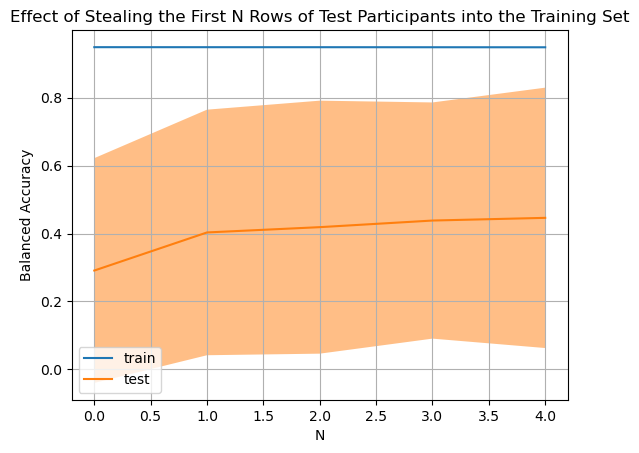

In [51]:
plt.figure()
tests = np.array(tests)
train = np.array(train)
test_errs = np.array(test_errs)
train_errs = np.array(train_errs)
plt.plot(range(5), trains, label='train')
plt.plot(range(5), tests, label='test')
plt.fill_between(range(5), trains - train_errs, trains + train_errs, alpha=0.5)
plt.fill_between(range(5), tests - test_errs, tests + test_errs, alpha=0.5)
plt.legend()
plt.grid()
plt.title('Effect of Stealing the First N Rows of Test Participants into the Training Set')
plt.xlabel('N')
plt.ylabel('Balanced Accuracy')

* Combine all the approaches developed separately to have nice experiments that make sense
* Compare with a completely random classifier
* I'll finish the RNN
* Try adding the number of days between data points as an extra feature

(array([  3.,   6.,  42., 146.,   0., 352., 162.,  31.,   5.,   1.]),
 array([-5. , -4.2, -3.4, -2.6, -1.8, -1. , -0.2,  0.6,  1.4,  2.2,  3. ]),
 <BarContainer object of 10 artists>)

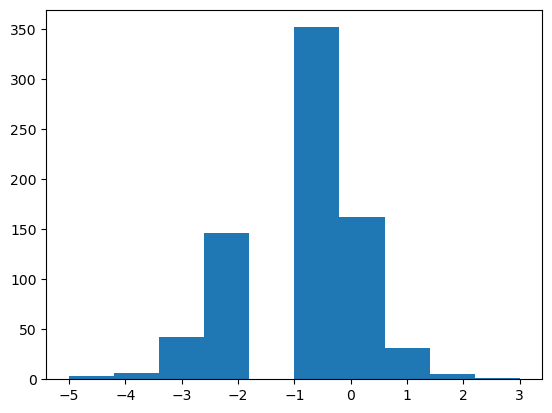

In [346]:
import matplotlib.pyplot as plt
plt.hist(y_train)

In [229]:
phq9.participant_id.unique().size
combined.participant_id.unique().size

285

In [500]:
def testf(df, method=['mean', 'std']):
    from collections import defaultdict
    inds = dp._group_by_phq9(df)
    
    def has_filt(col):
        return col.startswith('has_')
    
    def feature_filt(col):
        return col != 'target' and not col.startswith('has_')
    
    aggdict = {
        'target': 'last',
        **{c: 'max' for c in df.columns if has_filt(c)},
        **{c: method for c in df.columns if feature_filt(c)}
    }
    
    aggframe = df.groupby(inds).agg(aggdict)
    
    subcols = defaultdict(list)
    for name, sub in aggframe.columns.to_flat_index():
        subcols[name].append(sub)
        
    def rename_col(col):
        name, sub = col
        if len(subcols[name]) == 1:
            return name
        else:
            return '_'.join([name, sub])
    
    aggframe.columns = [rename_col(c) for c in aggframe.columns.to_flat_index()]
    return aggframe
    
d = merge_result.drop(columns=['date'])

a = d.groupby('participant_id').apply(testf)
k = 'home'
# a[~a['mean'].isna()]
# a.columns = ['_'.join(c) for c in a.columns.to_flat_index()]
a

target  has_phq9  has_locations  automotive_mean  \
participant_id                                                       
BLUE-00048     0     0.0      True          False              NaN   
BLUE-00050     0     1.0      True          False              NaN   
               1     0.0      True          False              NaN   
               2     0.0      True          False              NaN   
               3     0.0      True          False              NaN   
...                  ...       ...            ...              ...   
YELLOW-00262   2     1.0      True          False              NaN   
YELLOW-00263   0     2.0      True          False              NaN   
               1     1.0      True          False              NaN   
               2     1.0      True          False              NaN   
               3     1.0      True          False              NaN   

                  automotive_std  consumer_goods_mean  consumer_goods_std  \
participant_id                                                              
BLUE-00048     0             NaN                  NaN                 NaN   
BLUE-00050     0             NaN                  NaN                 NaN   
               1             NaN                  NaN                 NaN   
               2             NaN                  NaN                 NaN   
               3             NaN                  NaN                 NaN   
...                          ...                  ...                 ...   
YELLOW-00262   2             NaN                  NaN                 NaN   
YELLOW-00263   0             NaN                  NaN                 NaN   
               1             NaN                  NaN                 NaN   
               2             NaN                  NaN                 NaN   
               3             NaN                  NaN                 NaN   

                  dining_out_mean  dining_out_std  education_mean  ...  \
participant_id                                                     ...   
BLUE-00048     0              NaN             NaN             NaN  ...   
BLUE-00050     0              NaN             NaN             NaN  ...   
               1              NaN             NaN             NaN  ...   
               2              NaN             NaN             NaN  ...   
               3              NaN             NaN             NaN  ...   
...                           ...             ...             ...  ...   
YELLOW-00262   2              NaN             NaN             NaN  ...   
YELLOW-00263   0              NaN             NaN             NaN  ...   
               1              NaN             NaN             NaN  ...   
               2              NaN             NaN             NaN  ...   
               3              NaN             NaN             NaN  ...   

                  place_of_worship_mean  place_of_worship_std  repair_mean  \
participant_id                                                               
BLUE-00048     0                    NaN                   NaN          NaN   
BLUE-00050     0                    NaN                   NaN          NaN   
               1                    NaN                   NaN          NaN   
               2                    NaN                   NaN          NaN   
               3                    NaN                   NaN          NaN   
...                                 ...                   ...          ...   
YELLOW-00262   2                    NaN                   NaN          NaN   
YELLOW-00263   0                    NaN                   NaN          NaN   
               1                    NaN                   NaN          NaN   
               2                    NaN                   NaN          NaN   
               3                    NaN                   NaN          NaN   

                  repair_std  supermarket_mean  supermarket_std  transit_mean  \
participant_id                                

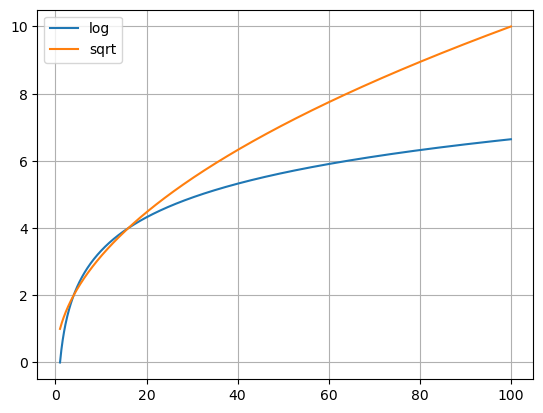

In [473]:
x = np.linspace(1, 100, 1000)
l = np.log2(x)
s = np.sqrt(x)

plt.figure()
plt.plot(x, l, label='log')
plt.plot(x, s, label='sqrt')
plt.legend()
plt.grid()


In [399]:
train_csv, test_csv = dp.train_test_split_exp(combined, 0.15, random_state=SEED, test_take_first=1)
a = test_csv.groupby('participant_id').head(1)
b = test_csv.groupby('participant_id').tail(-1)

In [220]:
x_train, x_test, y_train, y_test = dp.train_test_split_participant(combined, 0.15)
x_train.shape

(1008, 42) (153, 42)
0.14728682170542637


In [262]:
passive_mobility = dp.load_passive_mobility(DATADIR / 'df_passive_mobility_features.csv')
passive_mobility

,participant_id,dt_passive,came_to_work,distance_active,distance_high_speed_transportation,distance_powered_vehicle,distance_walking,hours_accounted_for,hours_active,hours_high_speed_transportation,hours_of_sleep,hours_powered_vehicle,hours_stationary,hours_stationary_nhw,hours_walking,location_variance
0,EN00538,2016-11-14,1.0,6284.6,0.0,0.0,5420.4,8,0.783,0.0,9.733,0.000,11.750,6.833,1.517,-5.261
1,EN00538,2016-11-15,1.0,15960.1,0.0,0.0,7120.3,24,1.733,0.0,0.133,0.000,20.133,3.833,2.117,-5.440
2,EN00538,2016-11-16,1.0,4359.7,0.0,9656.3,3456.6,12,0.567,0.0,0.167,0.183,11.767,4.817,0.917,-4.209
3,EN00538,2016-11-17,1.0,22387.9,0.0,1143.0,9809.7,16,2.583,0.0,0.200,0.050,25.883,17.900,2.467,-5.122
4,EN00538,2016-11-18,1.0,45277.7,0.0,22332.9,5856.4,24,5.500,0.0,0.167,0.550,16.467,3.967,1.467,-4.155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15351,EN05215,2016-11-25,0.0,10737.4,0.0,2685.7,0.0,2,0.783,0.0,5.567,0.083,0.000,0.000,0.000,-3.984
15352,EN05215,2016-11-26,1.0,3794.3,0.0,0.0,1844.3,7,0.350,0.0,2.683,0.000,10.717,4.667,0.383,-4.763
15353,EN05215,2016-11-27,1.0,1949.1,0.0,0.0,241.8,5,0.300,0.0,14.083,0.000,20.683,20.000,0.083,-5.478
15354,EN05215,2016-11-28,0.0,3113.3,0.0,5350.6,1241.7,5,0.350,0.0,0.250,0.183,27.117,27.117,0.267,-4.361


#### Random Forest Trial

In [334]:
combined # combined.loc[:, 'automotive':'work']

,participant_id,target,working,income_satisfaction,income_lastyear,age,gen_Female,gen_Male,martial_Married/Partner,martial_Separated/Widowed/Divorced,...,edu_None,edu_University,race_African-American/Black,race_American Indian/Alaskan Native,race_Asian,race_Hispanic/Latino,race_More than one,race_Native Hawaiian/other Pacific Islander,race_Non-Hispanic White,race_Other
0,EN00035,0.0,0.0,2.0,2.0,57.0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
1,EN00035,0.0,0.0,2.0,2.0,57.0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
2,EN00035,0.0,0.0,2.0,2.0,57.0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
3,EN00035,0.0,0.0,2.0,2.0,57.0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
4,EN00039,3.0,1.0,2.0,1.0,51.0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,ES05073,2.0,0.0,3.0,4.0,45.0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1157,ES05073,2.0,0.0,3.0,4.0,45.0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1158,ES05073,0.0,0.0,3.0,4.0,45.0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1159,ES05073,4.0,0.0,3.0,4.0,45.0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [277]:
df = merge_result # merge_result.reindex(sorted(merge_result.columns), axis=1)
df[df.participant_id == 'EN00041']

,participant_id,date,target,has_phq9,automotive,consumer_goods,dining_out,education,entertainment,finance,...,hours_accounted_for,hours_active,hours_high_speed_transportation,hours_of_sleep,hours_powered_vehicle,hours_stationary,hours_stationary_nhw,hours_walking,location_variance,has_mobility
4180,EN00041,2016-08-19,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4152,EN00041,2016-09-02,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3723,EN00041,2016-09-09,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4839,EN00041,2016-09-12,NaN,False,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.200,0.000,9.983,0.000,5.700,3.900,0.700,-4.662,True
17394,EN00041,2016-09-13,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,0.217,0.000,3.483,2.000,15.400,12.350,0.500,-1.731,True
17395,EN00041,2016-09-14,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,1.067,0.900,1.283,3.200,14.600,14.600,1.083,0.437,True
4840,EN00041,2016-09-15,NaN,False,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.267,0.000,5.267,0.067,17.467,1.200,0.650,-5.045,True
4413,EN00041,2016-09-16,0.0,True,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.950,0.000,1.667,1.050,17.583,16.017,0.917,-2.715,True
4841,EN00041,2016-09-17,NaN,False,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.667,0.000,3.450,0.183,18.100,13.633,0.600,-4.039,True
4842,EN00041,2016-09-18,NaN,False,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.800,0.000,15.600,0.467,16.317,3.467,0.717,-2.967,True


In [300]:
phq9 = pd.read_csv(DATADIR / 'df_phq9.csv')
s = phq9.loc[:, 'phq9_1':'phq9_9'].sum(axis=1)

In [279]:
merge_result

,participant_id,date,target,has_phq9,automotive,consumer_goods,dining_out,education,entertainment,finance,...,hours_accounted_for,hours_active,hours_high_speed_transportation,hours_of_sleep,hours_powered_vehicle,hours_stationary,hours_stationary_nhw,hours_walking,location_variance,has_mobility
0,BLUE-00048,2014-08-08,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,BLUE-00050,2014-08-23,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,BLUE-00050,2014-08-30,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,BLUE-00050,2014-09-08,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,BLUE-00050,2014-09-22,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3622,YELLOW-00262,2014-12-31,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3623,YELLOW-00263,2014-12-17,2.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3624,YELLOW-00263,2014-12-24,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3625,YELLOW-00263,2014-12-31,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [321]:
a = phq9.groupby('participant_id').apply(lambda x: x['target'].shift(1))
b = pd.DataFrame()
a = a.reset_index(drop=True)
b['target'] = a
b

,target
0,NaN
1,NaN
2,1.0
3,0.0
4,0.0
...,...
4786,1.0
4787,NaN
4788,2.0
4789,1.0
